Rodolfo Amaya

CS 545 

Colorado State University

Fall 2019

# Table of Contents
* [Title](#A3.3-Classification)
    * [Summary and Conclusion](#Summary-and-Conclusion)
    * [Data Preparation](#Data-Preparation)
	* [Neural Networks SCG](#Neural-Networks-SCG)
	* [Neural Networks SGD](#Neural-Networks-SGD)
	* [Neural Networks ADAM](#Neural-Networks-ADAM)
    * [Scikit Random Forest Regression](#Scikit-Random-Forest-Regression)
    * [Scikit Gradient Boost Regression](#Scikit-Gradient-Boost-Regression)
    * [Scikit Nearest Neighbors Regression](#Scikit-Nearest-Neighbors-Regression)
        * [Uniform Weights](#Uniform-Weights)
        * [Distance Weights](#Distance-Weights)
    * [Scikit Support Vector Machine Regression](#Scikit-Support-Vector-Machine-Regression)
    * [Scikit Dimensional Reduction](#Scikit-Dimensional-Reduction)
        * [Nearest Neighbors Reduced](#Nearest-Neighbors-Regression-Reduced)
        * [Random Forest Reduced](#Random-Forest-Regression-Reduced)
        * [Support Vector Machine Reduced](#Support-Vector-Machine-Reduced)
    * [Nearest Neighbors Revisited](#Nearest-Neighbors-Regression-Revisited)
    * [Random Forest Revisited](#Random-Forest-with-Reduction-Revisited)


# Summary and Conclusion

The different machine learning methods produced widely different results. The difference in results is explained by the how each algorithm assigns weights to the inputs. The superconductor data set has outputs that do not correlate well with any of the inputs. About 50% of the variance in outputs is explained by a single variable: range of thermal conductivity. About 10% of the other variance is accounted for by only 1-3 other variables in the data set. The remainder of the variables account for almost no variance and only introduce noise into each algorithm. 

This means that algorithms that assign uniform weights to the data and make assumptions perform very poorly on this data set. The gradient boost and support vector machines appear to assume that the data is correlated as they train by looking at the error of each previous iteration through the data set. This compounds the errors as the variables in the data do not account for all the variance.

On the other hand, methods that made no assumptions on the data and gave weighted 1-3 variables more heavily, produced the best results and also happened to be some of the fastest to train themselves on the data. The nearest neighbors approach and random forest methods achieved the highest accuracies. In the case of random forests, the model trained thousands of decision trees and utilized the average of all the errors while weighing the range of thermal conductivity more heavily. In the case of nearest neighbors, there was no underlying training, but instead the model grouped the range of thermal conductivites for the various temperatures and assumed that the range of thermal conductivity accounted for most of the variance.

Although a percentage of test correct of 95% or greater was not achieved with any of the models unless the accuracy threshold was lowered, the project provided a valuable insight into using machine learning. 

The first is to not look at the number of inputs as a measure of the complexity of the data set. Techniques such as dimensional reduction, nearest neighbors and gradient boosting are excellent tools to deconstruct a data set into the variables that account for most of the variance. Instead, it is best to obtain an analysis of how well the inputs correlate with the outputs. If the data is not well correlated, the trained models will only do as well as the most correlated variable. If more accuracy is desired, then additional variables will need to be collected. Although the data set of interest to my field has a large amount of inputs like the superconductor data set, it is likely that some of the inputs will account for such a tiny percentage of the variance that they can be discarded and greatly reduce the computational load required to use the trained model.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import sys

import torch
import mlutilities as ml  # for ml.draw
import optimizers as opt  # for opt.sgd, opt.adam, and opt.scg

import neuralnetworks as nn
import pandas as pd

import time

# Data Preparation

The superconductor data set is in the form of two csv files. One contains the superconductor list with elemental composition attributes and the other contains the same superconductor list with thermodynamic and atomic properties. The list with the thermodynamic properties was chosen because of it did not contain large amounts of zero valued fields as the elemental one. 
This effectively reduces the uniqueness of each superconductor and makes the temperature more difficult to predict. 

Load the superconductor data into a pandas data frame and visualize the columns of data.

In [2]:
SuperconductorFrame = pd.read_excel('superconductor.xlsx', 'train', index_col=None)
SuperconductorFrame

,number_of_elements,mean_atomic_mass,wtd_mean_atomic_mass,gmean_atomic_mass,wtd_gmean_atomic_mass,entropy_atomic_mass,wtd_entropy_atomic_mass,range_atomic_mass,wtd_range_atomic_mass,std_atomic_mass,...,wtd_mean_Valence,gmean_Valence,wtd_gmean_Valence,entropy_Valence,wtd_entropy_Valence,range_Valence,wtd_range_Valence,std_Valence,wtd_std_Valence,critical_temp
0,4,88.944468,57.862692,66.361592,36.116612,1.181795,1.062396,122.90607,31.794921,51.968828,...,2.257143,2.213364,2.219783,1.368922,1.066221,1,1.085714,0.433013,0.437059,29.00
1,5,92.729214,58.518416,73.132787,36.396602,1.449309,1.057755,122.90607,36.161939,47.094633,...,2.257143,1.888175,2.210679,1.557113,1.047221,2,1.128571,0.632456,0.468606,26.00
2,4,88.944468,57.885242,66.361592,36.122509,1.181795,0.975980,122.90607,35.741099,51.968828,...,2.271429,2.213364,2.232679,1.368922,1.029175,1,1.114286,0.433013,0.444697,19.00
3,4,88.944468,57.873967,66.361592,36.119560,1.181795,1.022291,122.90607,33.768010,51.968828,...,2.264286,2.213364,2.226222,1.368922,1.048834,1,1.100000,0.433013,0.440952,22.00
4,4,88.944468,57.840143,66.361592,36.110716,1.181795,1.129224,122.90607,27.848743,51.968828,...,2.242857,2.213364,2.206963,1.368922,1.096052,1,1.057143,0.433013,0.428809,23.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21258,4,106.957877,53.095769,82.515384,43.135565,1.177145,1.254119,146.88130,15.504479,65.764081,...,3.555556,3.223710,3.519911,1.377820,0.913658,1,2.168889,0.433013,0.496904,2.44
21259,5,92.266740,49.021367,64.812662,32.867748,1.323287,1.571630,188.38390,7.353333,69.232655,...,2.047619,2.168944,2.038991,1.594167,1.337246,1,0.904762,0.400000,0.212959,122.10
21260,2,99.663190,95.609104,99.433882,95.464320,0.690847,0.530198,13.51362,53.041104,6.756810,...,4.800000,4.472136,4.781762,0.686962,0.450561,1,3.200000,0.500000,0.400000,1.98
21261,2,99.663190,97.095602,99.433882,96.901083,0.690847,0.640883,13.51362,31.115202,6.756810,...,4.690000,4.472136,4.665819,0.686962,0.577601,1,2.210000,0.500000,0.462493,1.84


Obtain the names of the columns.

In [3]:
names = list(SuperconductorFrame.columns.values)
names

['number_of_elements',
 'mean_atomic_mass',
 'wtd_mean_atomic_mass',
 'gmean_atomic_mass',
 'wtd_gmean_atomic_mass',
 'entropy_atomic_mass',
 'wtd_entropy_atomic_mass',
 'range_atomic_mass',
 'wtd_range_atomic_mass',
 'std_atomic_mass',
 'wtd_std_atomic_mass',
 'mean_fie',
 'wtd_mean_fie',
 'gmean_fie',
 'wtd_gmean_fie',
 'entropy_fie',
 'wtd_entropy_fie',
 'range_fie',
 'wtd_range_fie',
 'std_fie',
 'wtd_std_fie',
 'mean_atomic_radius',
 'wtd_mean_atomic_radius',
 'gmean_atomic_radius',
 'wtd_gmean_atomic_radius',
 'entropy_atomic_radius',
 'wtd_entropy_atomic_radius',
 'range_atomic_radius',
 'wtd_range_atomic_radius',
 'std_atomic_radius',
 'wtd_std_atomic_radius',
 'mean_Density',
 'wtd_mean_Density',
 'gmean_Density',
 'wtd_gmean_Density',
 'entropy_Density',
 'wtd_entropy_Density',
 'range_Density',
 'wtd_range_Density',
 'std_Density',
 'wtd_std_Density',
 'mean_ElectronAffinity',
 'wtd_mean_ElectronAffinity',
 'gmean_ElectronAffinity',
 'wtd_gmean_ElectronAffinity',
 'entropy_E

Divide the names into input names and target names.

In [4]:
Xnames_SuperCond = names[0:-1]
Tname_SuperCond = names[-1]
Xnames_SuperCond, Tname_SuperCond

(['number_of_elements',
  'mean_atomic_mass',
  'wtd_mean_atomic_mass',
  'gmean_atomic_mass',
  'wtd_gmean_atomic_mass',
  'entropy_atomic_mass',
  'wtd_entropy_atomic_mass',
  'range_atomic_mass',
  'wtd_range_atomic_mass',
  'std_atomic_mass',
  'wtd_std_atomic_mass',
  'mean_fie',
  'wtd_mean_fie',
  'gmean_fie',
  'wtd_gmean_fie',
  'entropy_fie',
  'wtd_entropy_fie',
  'range_fie',
  'wtd_range_fie',
  'std_fie',
  'wtd_std_fie',
  'mean_atomic_radius',
  'wtd_mean_atomic_radius',
  'gmean_atomic_radius',
  'wtd_gmean_atomic_radius',
  'entropy_atomic_radius',
  'wtd_entropy_atomic_radius',
  'range_atomic_radius',
  'wtd_range_atomic_radius',
  'std_atomic_radius',
  'wtd_std_atomic_radius',
  'mean_Density',
  'wtd_mean_Density',
  'gmean_Density',
  'wtd_gmean_Density',
  'entropy_Density',
  'wtd_entropy_Density',
  'range_Density',
  'wtd_range_Density',
  'std_Density',
  'wtd_std_Density',
  'mean_ElectronAffinity',
  'wtd_mean_ElectronAffinity',
  'gmean_ElectronAffinity'

In [5]:
X = SuperconductorFrame[SuperconductorFrame.columns[0:81].values]
X = np.array(X).astype('float')
X

array([[ 4.        , 88.9444675 , 57.86269229, ...,  1.08571429,
         0.4330127 ,  0.43705882],
       [ 5.        , 92.729214  , 58.51841614, ...,  1.12857143,
         0.63245553,  0.46860627],
       [ 4.        , 88.9444675 , 57.88524186, ...,  1.11428571,
         0.4330127 ,  0.44469664],
       ...,
       [ 2.        , 99.66319   , 95.609104  , ...,  3.2       ,
         0.5       ,  0.4       ],
       [ 2.        , 99.66319   , 97.0956022 , ...,  2.21      ,
         0.5       ,  0.46249324],
       [ 3.        , 87.46833333, 86.8585    , ...,  1.8       ,
         1.41421356,  1.5       ]])

In [6]:
X.shape[0], X.shape[1]

(21263, 81)

In [7]:
T = SuperconductorFrame[SuperconductorFrame.columns.values[-1]]
T = np.array(T).astype('float')
T = np.reshape(T, (-1, 1))
T

array([[29.  ],
       [26.  ],
       [19.  ],
       ...,
       [ 1.98],
       [ 1.84],
       [12.8 ]])

Partition the data into 80% training and 20% test samples.

In [8]:
nrows = X.shape[0]
nTrain = int(round(nrows*0.8))
nTest = nrows - nTrain
nTrain, nTest, nTrain+nTest

(17010, 4253, 21263)

In [9]:
rows = np.arange(nrows)
np.random.shuffle(rows)
rows

array([15551,  2227,  2974, ..., 20867, 10397,  8070])

In [10]:
trainIndices = rows[:nTrain]
testIndices = rows[nTrain:]
trainIndices, testIndices

(array([15551,  2227,  2974, ...,  1263,  3184, 11136]),
 array([ 9961, 11080,  3914, ..., 20867, 10397,  8070]))

In [11]:
np.intersect1d(trainIndices, testIndices)

array([], dtype=int64)

In [12]:
Xtrain_SuperCond = X[trainIndices, :]
Ttrain_SuperCond = T[trainIndices, :]
Xtest_SuperCond = X[testIndices, :]
Ttest_SuperCond = T[testIndices, :]

Xtrain_SuperCondS = (Xtrain_SuperCond - Xtrain_SuperCond.mean(axis=0)) / Xtrain_SuperCond.std(axis=0)
Xtest_SuperCondS = (Xtest_SuperCond- Xtrain_SuperCond.mean(axis=0)) / Xtrain_SuperCond.std(axis=0)

Xtrain_SuperCondS.mean(0), Xtrain_SuperCondS.std(0), Xtest_SuperCondS.mean(0), Xtest_SuperCondS.std(0)

(array([-1.27258580e-15, -6.20022421e-14,  7.74008854e-15, -4.29102178e-15,
        -6.50261737e-15, -1.43294613e-14, -1.39839508e-14,  5.83507636e-14,
        -2.93839027e-15,  1.61061314e-14,  1.65908178e-15, -1.35573393e-13,
        -1.67704050e-14, -4.01250984e-15,  5.65426339e-14, -4.78686070e-14,
        -2.90522456e-14,  2.26845168e-13, -1.15823960e-14,  1.09231325e-15,
         1.63264790e-15,  2.74507701e-15,  1.59057560e-15,  6.20023335e-14,
        -1.76327239e-14, -3.14977386e-14,  1.84048609e-14,  8.83087450e-17,
         9.39512498e-15,  5.17315892e-14, -2.41904609e-15, -4.67206912e-14,
        -5.31772679e-15,  1.07557245e-14,  6.86743757e-15, -1.73313632e-14,
         2.10030569e-15,  1.38527298e-13, -3.98151693e-15, -1.06204418e-14,
         1.72738302e-14, -3.78685260e-14,  1.40488836e-14,  1.62871872e-15,
         2.64009730e-14, -1.12581758e-13,  1.80954344e-14,  6.32757678e-14,
         2.90084763e-14,  4.03845746e-14,  3.53253255e-14,  6.21409515e-14,
         5.4

In [13]:
Xtrain_SuperCond.shape, Xtest_SuperCond.shape, X.shape

((17010, 81), (4253, 81), (21263, 81))

In [14]:
Ttrain_SuperCond.shape, Ttest_SuperCond.shape, T.shape

((17010, 1), (4253, 1), (21263, 1))

In [15]:
Xtrain_SuperCondS.shape, Xtest_SuperCondS.shape

((17010, 81), (4253, 81))

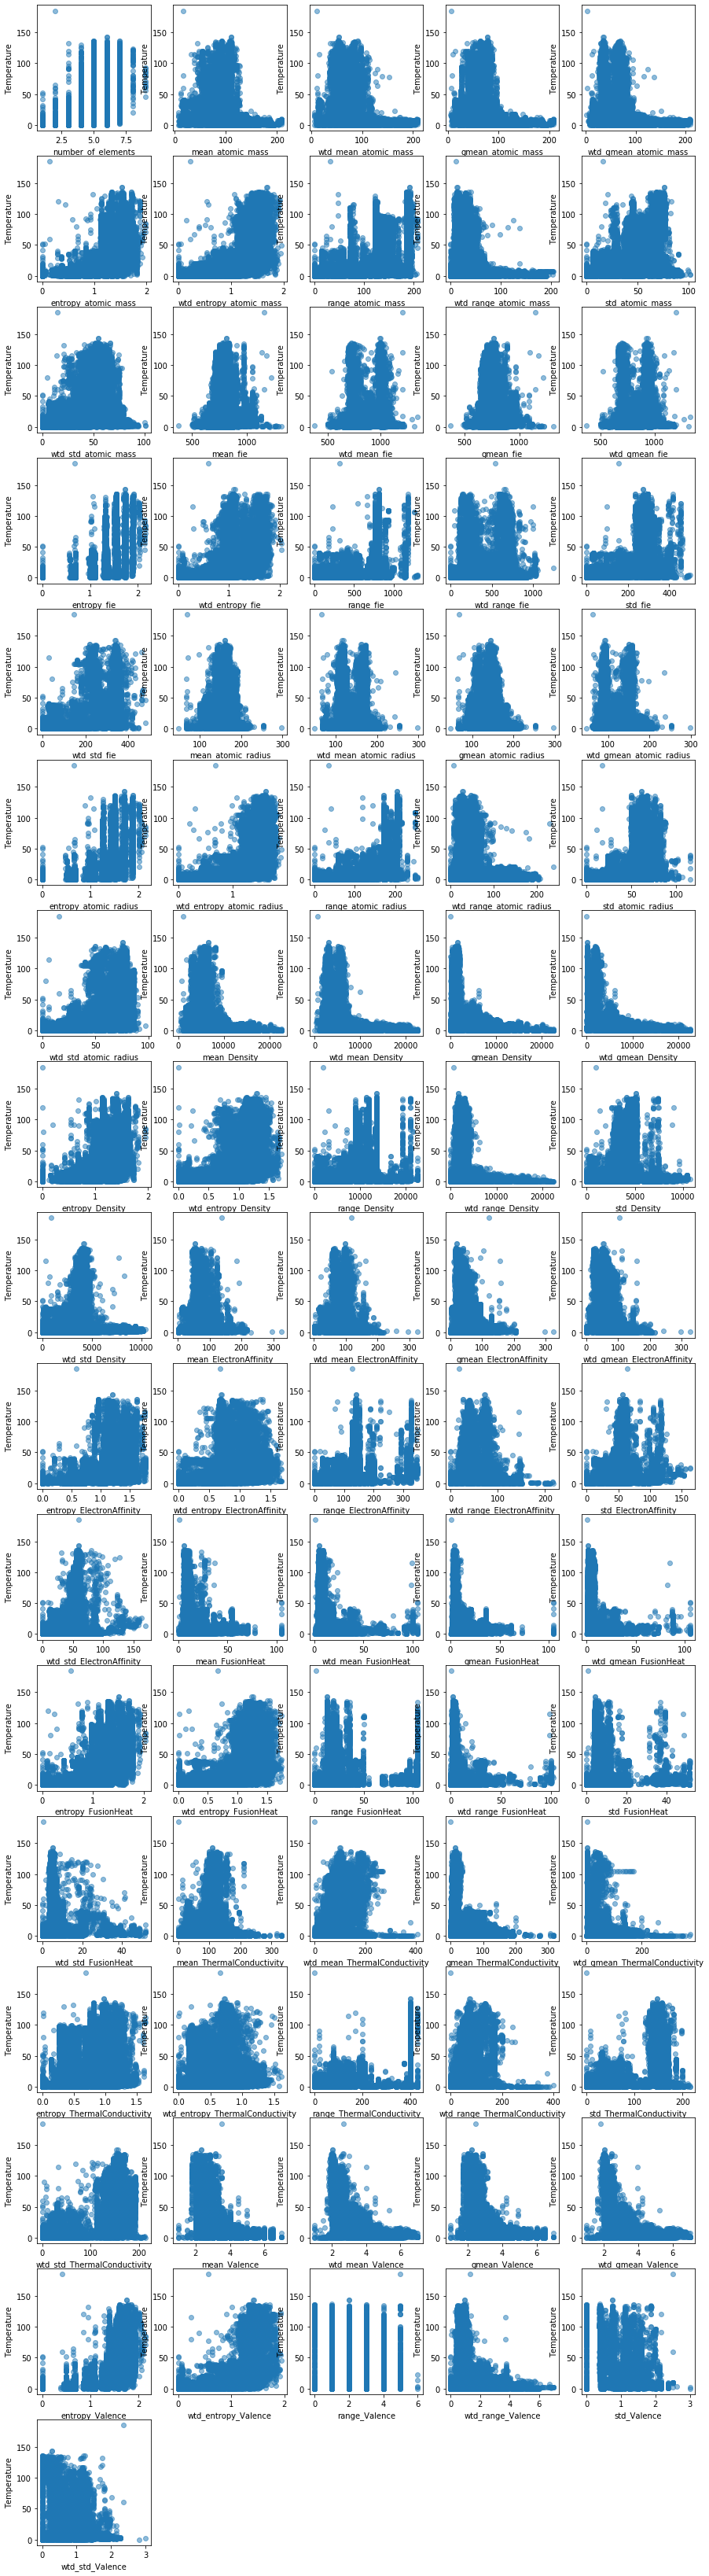

In [16]:
plt.figure(figsize=(15, 70))
for c in range(X.shape[1]):
    plt.subplot(20,5, c+1)
    plt.plot(X[:, c], T, 'o', alpha=0.5)
    plt.ylabel("Temperature")
    plt.xlabel(Xnames_SuperCond[c])

# Methods and Procedures

Different regression tools are used to predict the critical temperature of each superconductor. A tool is considered ideal if it can predict the critical temperature with an error less than 5-10%. 

The tests begin using the in-class methods of SCG, SGD, and ADAM. This helps produce a baseline to which the external methods can be compared to. Additionally a method is only considered acceptable if it can produce better results than a linear average of the superconductor temperatures. This is because taking an average of all the temepratures does is not computationally intensive and if a any method cannot be more accurate than linear interpolation, then it can be considered a failure.

The fastest and most accurate methods are then examined in more detail. Of interest is which variables they weigh most heavily (which inputs produce the most variance) and 

# Average of all Temperatures

The average of all temperatures is the simplest model that can be obtained.

In [17]:
Y = np.average(Ttrain_SuperCond)

In [18]:
Y

34.58694790681952

In [19]:
errors = abs(Y - Ttest_SuperCond)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
n_correct = ((abs(Y - Ttest_SuperCond) < (Ttest_SuperCond/10.))).sum()
print(f'{n_correct} out of {Ttest_SuperCond.shape[0]} samples, or {n_correct/Ttest_SuperCond.shape[0]*100:.2f} percent.')

Mean Absolute Error: 29.31 degrees.
218 out of 4253 samples, or 5.13 percent.


In [20]:
errors = abs(Y - Ttest_SuperCond)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
n_correct = ((abs(Y - Ttest_SuperCond) < (Ttest_SuperCond/20.))).sum()
print(f'{n_correct} out of {Ttest_SuperCond.shape[0]} samples, or {n_correct/Ttest_SuperCond.shape[0]*100:.2f} percent.')

Mean Absolute Error: 29.31 degrees.
94 out of 4253 samples, or 2.21 percent.


In order to be considered a success, the subsequent models need to be able to get at least ~2.33 percent of the test samples correct.

# Neural Networks SCG

The best runs for SCG are shown commented. SCG gets more samples correct than the baseline, but is still not close enough for a 90% accuracy on the test set.

In [21]:
#nnet_extra = nn.NeuralNetwork(81, [20, 20, 20, 20], 1) #0.316
#nnet_extra = nn.NeuralNetwork(81, [30, 30, 30 , 30], 1) #0.289
#nnet_extra = nn.NeuralNetwork(81, [50, 50, 50, 50], 1) #0.280 #5k

nnet_extra = nn.NeuralNetwork(81, [30, 30, 30, 30, 30], 1)
nnet_extra.train(Xtrain_SuperCond, Ttrain_SuperCond, 10000, verbose=True)

SCG: Iteration 1000 ObjectiveF=0.29960 Scale=1.000e-15 Seconds=102.221
SCG: Iteration 2000 ObjectiveF=0.28300 Scale=1.000e-15 Seconds=96.190
SCG: Iteration 3000 ObjectiveF=0.27863 Scale=1.000e-15 Seconds=101.389
SCG: Iteration 4000 ObjectiveF=0.27454 Scale=1.000e-15 Seconds=94.808
SCG: Iteration 5000 ObjectiveF=0.27134 Scale=1.000e-15 Seconds=95.308
SCG: Iteration 6000 ObjectiveF=0.26862 Scale=1.000e-15 Seconds=94.723
SCG: Iteration 7000 ObjectiveF=0.26621 Scale=1.000e-15 Seconds=94.196
SCG: Iteration 8000 ObjectiveF=0.26407 Scale=1.000e-15 Seconds=93.811
SCG: Iteration 9000 ObjectiveF=0.26219 Scale=1.000e-15 Seconds=94.459
SCG: Iteration 10000 ObjectiveF=0.26052 Scale=1.000e-15 Seconds=94.413


NeuralNetwork(81, [30, 30, 30, 30, 30], 1, use_torch=False)
   Network was trained for 10000 epochs that took 961.5614 seconds. Final objective value is 0.261

In [22]:
Y = nnet_extra.use(Xtest_SuperCond)

In [23]:
Y

array([[51.17822048],
       [10.12002215],
       [33.95127833],
       ...,
       [ 2.11473554],
       [ 4.98630317],
       [54.76528001]])

In [24]:
Ttest_SuperCond

array([[71.  ],
       [ 7.1 ],
       [33.2 ],
       ...,
       [ 2.9 ],
       [ 9.67],
       [38.  ]])

In [25]:
errors = abs(Y - Ttest_SuperCond)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
n_correct = ((abs(Y - Ttest_SuperCond) < (Ttest_SuperCond/10.))).sum()
print(f'{n_correct} out of {Ttest_SuperCond.shape[0]} samples, or {n_correct/Ttest_SuperCond.shape[0]*100:.2f} percent.')

Mean Absolute Error: 9.02 degrees.
824 out of 4253 samples, or 19.37 percent.


In [26]:
errors = abs(Y - Ttest_SuperCond)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
n_correct = ((abs(Y - Ttest_SuperCond) < (Ttest_SuperCond/20.))).sum()
print(f'{n_correct} out of {Ttest_SuperCond.shape[0]} samples, or {n_correct/Ttest_SuperCond.shape[0]*100:.2f} percent.')

Mean Absolute Error: 9.02 degrees.
400 out of 4253 samples, or 9.41 percent.


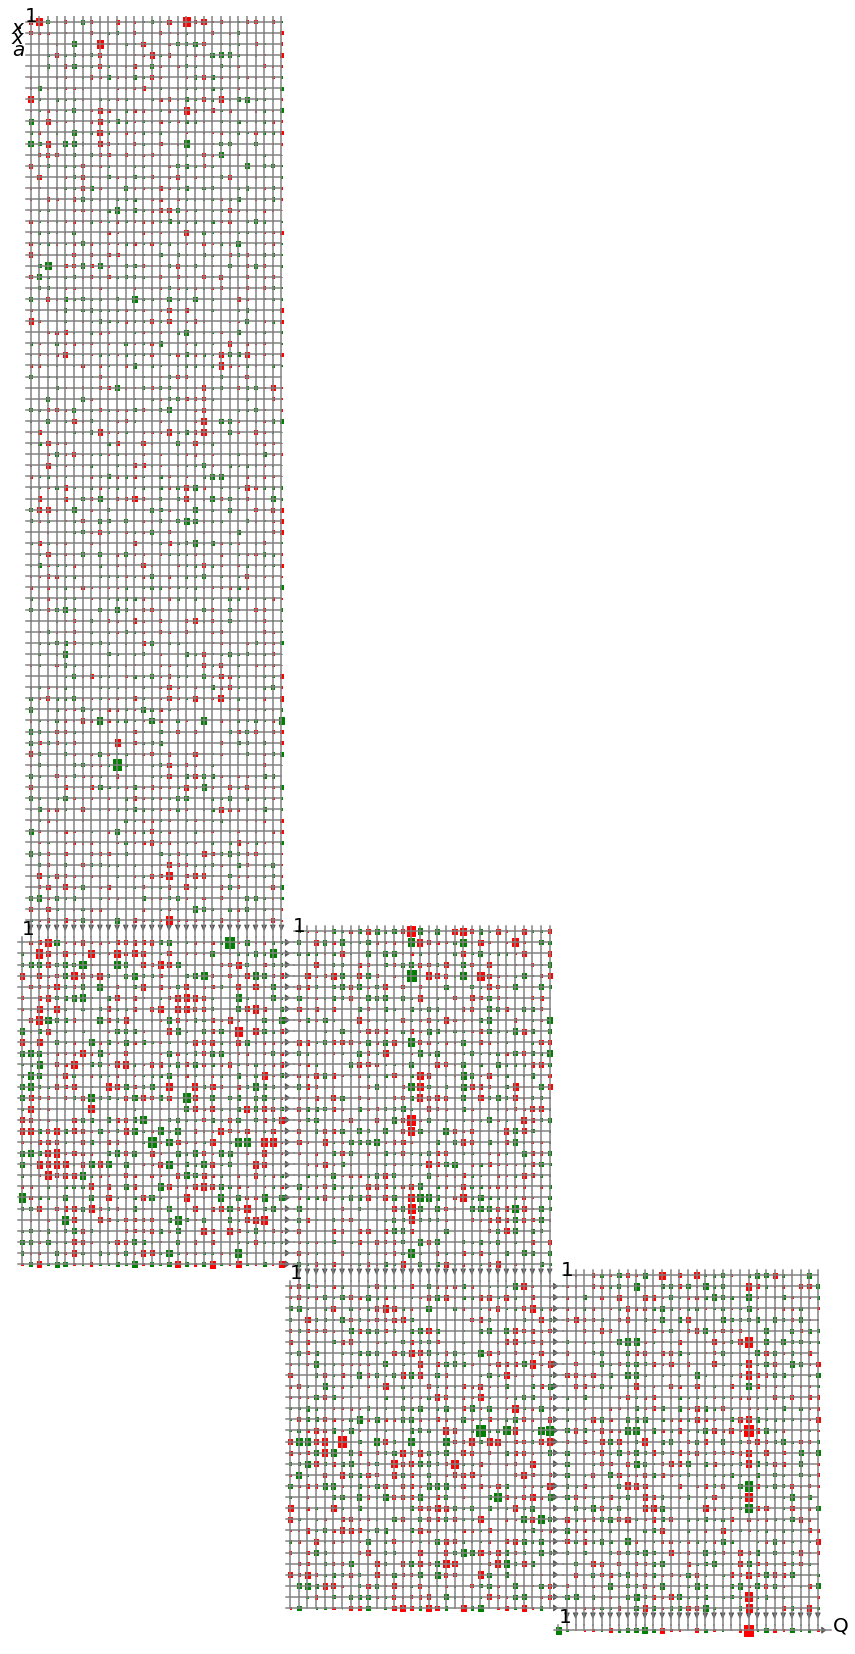

In [27]:
fig = plt.figure(figsize=(15, 30))
nnet_extra.draw(['$x$', '$\dot{x}$', '$a$'], ['Q'])

# Neural Networks SGD

SGD's best network only achieved performance slightly better than taking the average of all the temperatures. 

In [28]:
#nnet_extra = nn.NeuralNetwork(81, [30, 30, 30, 30], 1) #10k = 0.391
nnet_extra = nn.NeuralNetwork(81, [20, 20, 20], 1)
nnet_extra.train(Xtrain_SuperCond, Ttrain_SuperCond, 10000, method='sgd', verbose=True)

sgd: Iteration 1000 ObjectiveF=0.50491 Seconds=24.739
sgd: Iteration 2000 ObjectiveF=0.46172 Seconds=24.656
sgd: Iteration 3000 ObjectiveF=0.44508 Seconds=24.786
sgd: Iteration 4000 ObjectiveF=0.43200 Seconds=24.422
sgd: Iteration 5000 ObjectiveF=0.42136 Seconds=24.724
sgd: Iteration 6000 ObjectiveF=0.41297 Seconds=24.545
sgd: Iteration 7000 ObjectiveF=0.40625 Seconds=24.438
sgd: Iteration 8000 ObjectiveF=0.40057 Seconds=24.889
sgd: Iteration 9000 ObjectiveF=0.39551 Seconds=24.763
sgd: Iteration 10000 ObjectiveF=0.39087 Seconds=24.406


NeuralNetwork(81, [20, 20, 20], 1, use_torch=False)
   Network was trained for 10000 epochs that took 246.3843 seconds. Final objective value is 0.391

In [29]:
Y = nnet_extra.use(Xtest_SuperCond)

In [30]:
Y

array([[70.02863421],
       [25.80756735],
       [52.90361563],
       ...,
       [-2.87978563],
       [17.61657994],
       [65.60508946]])

In [31]:
Ttest_SuperCond

array([[71.  ],
       [ 7.1 ],
       [33.2 ],
       ...,
       [ 2.9 ],
       [ 9.67],
       [38.  ]])

In [32]:
errors = abs(Y - Ttest_SuperCond)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
n_correct = ((abs(Y - Ttest_SuperCond) < (Ttest_SuperCond/10.))).sum()
print(f'{n_correct} out of {Ttest_SuperCond.shape[0]} samples, or {n_correct/Ttest_SuperCond.shape[0]*100:.2f} percent.')

Mean Absolute Error: 14.43 degrees.
432 out of 4253 samples, or 10.16 percent.


In [33]:
errors = abs(Y - Ttest_SuperCond)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
n_correct = ((abs(Y - Ttest_SuperCond) < (Ttest_SuperCond/20.))).sum()
print(f'{n_correct} out of {Ttest_SuperCond.shape[0]} samples, or {n_correct/Ttest_SuperCond.shape[0]*100:.2f} percent.')

Mean Absolute Error: 14.43 degrees.
208 out of 4253 samples, or 4.89 percent.


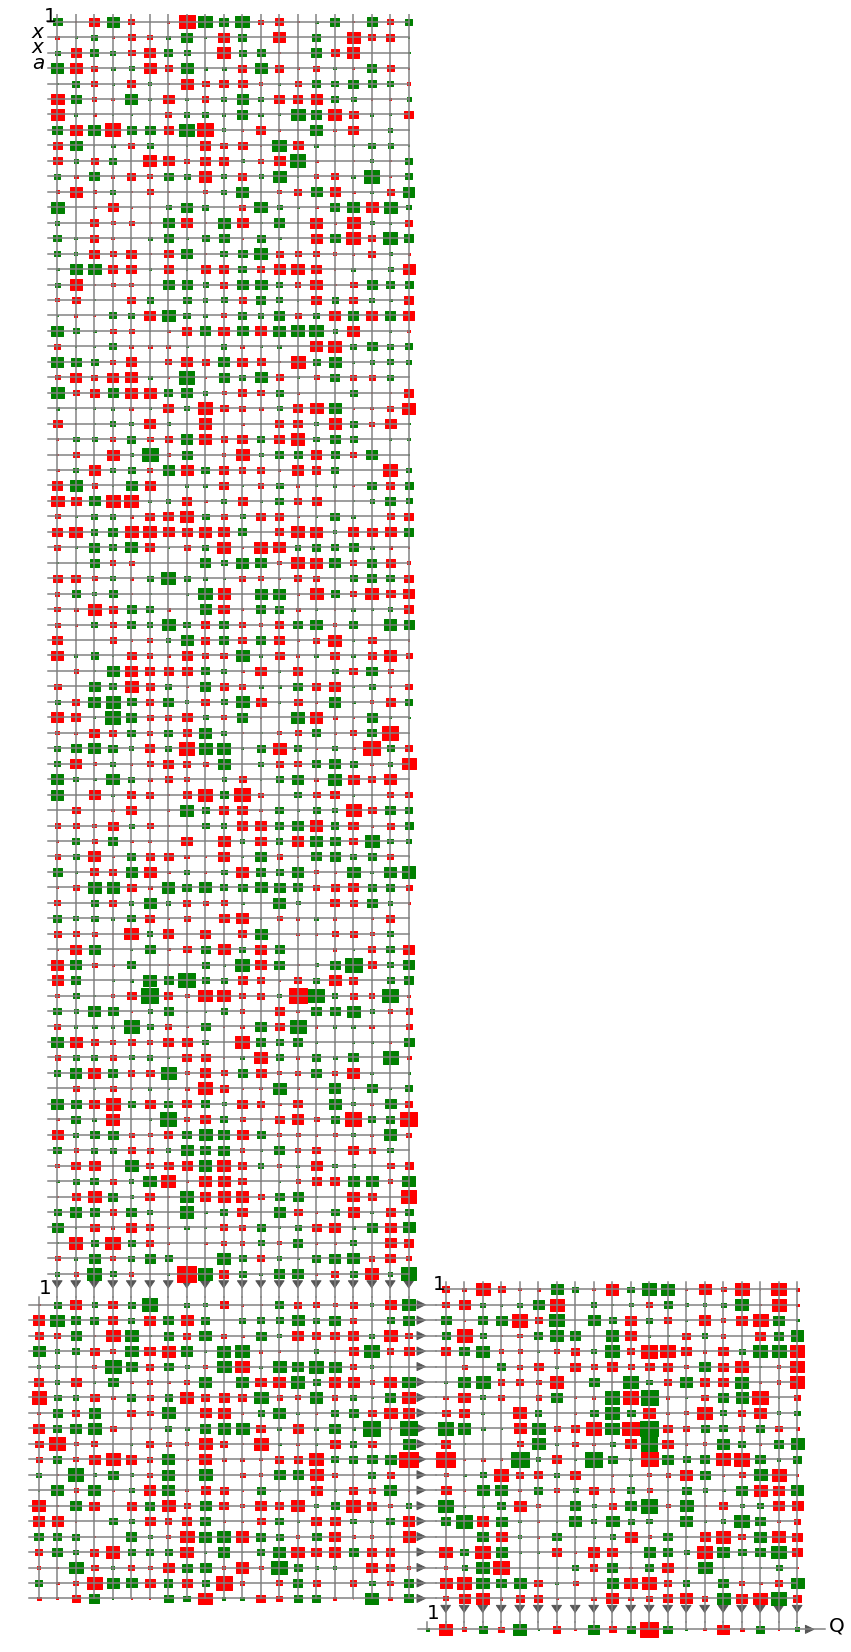

In [34]:
fig = plt.figure(figsize=(15, 30))
nnet_extra.draw(['$x$', '$\dot{x}$', '$a$'], ['Q'])

# Neural Networks ADAM

The ADAM technique performed best of all the in-class techniques. It benefitted from a large network to about [60,60,60,60] after which performance began to decrease and training times to increase. Another observation about ADAM is that its peformance was much higher with unstandardized inputs. Unlike the other techniques, ADAM benefitted from a large number of iterations. Even more surprisingly, this did not reduce its peformance on the test set, indicating that the training and test sets were closely correlated. 

In [35]:
#nnet_extra = nn.NeuralNetwork(81, [30, 30, 30, 30], 1) #10k = 0.185
#nnet_extra = nn.NeuralNetwork(81, [50, 50, 50, 50], 1) #10k = 0.167
nnet_extra = nn.NeuralNetwork(81, [60, 60, 60, 60], 1)
nnet_extra.train(Xtrain_SuperCondS, Ttrain_SuperCond, 10000, method='adam', verbose=True)

adam: Iteration 1000 ObjectiveF=0.25225 Seconds=86.971
adam: Iteration 2000 ObjectiveF=0.22477 Seconds=86.433
adam: Iteration 3000 ObjectiveF=0.20655 Seconds=86.015
adam: Iteration 4000 ObjectiveF=0.19554 Seconds=86.736
adam: Iteration 5000 ObjectiveF=0.19061 Seconds=86.685
adam: Iteration 6000 ObjectiveF=0.18397 Seconds=86.964
adam: Iteration 7000 ObjectiveF=0.17370 Seconds=88.656
adam: Iteration 8000 ObjectiveF=0.16815 Seconds=87.315
adam: Iteration 9000 ObjectiveF=0.16901 Seconds=86.752
adam: Iteration 10000 ObjectiveF=0.15718 Seconds=86.312


NeuralNetwork(81, [60, 60, 60, 60], 1, use_torch=False)
   Network was trained for 10000 epochs that took 868.8712 seconds. Final objective value is 0.157

In [36]:
Y = nnet_extra.use(Xtest_SuperCondS)

In [37]:
Y

array([[49.94962717],
       [ 3.56857722],
       [33.07703127],
       ...,
       [ 3.53116594],
       [ 7.37885945],
       [45.64588079]])

In [38]:
Ttest_SuperCond

array([[71.  ],
       [ 7.1 ],
       [33.2 ],
       ...,
       [ 2.9 ],
       [ 9.67],
       [38.  ]])

In [39]:
errors = abs(Y - Ttest_SuperCond)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
n_correct = ((abs(Y - Ttest_SuperCond) < (Ttest_SuperCond/10.))).sum()
print(f'{n_correct} out of {Ttest_SuperCond.shape[0]} samples, or {n_correct/Ttest_SuperCond.shape[0]*100:.2f} percent.')

Mean Absolute Error: 6.45 degrees.
1298 out of 4253 samples, or 30.52 percent.


In [40]:
errors = abs(Y - Ttest_SuperCond)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
n_correct = ((abs(Y - Ttest_SuperCond) < (Ttest_SuperCond/20.))).sum()
print(f'{n_correct} out of {Ttest_SuperCond.shape[0]} samples, or {n_correct/Ttest_SuperCond.shape[0]*100:.2f} percent.')

Mean Absolute Error: 6.45 degrees.
752 out of 4253 samples, or 17.68 percent.


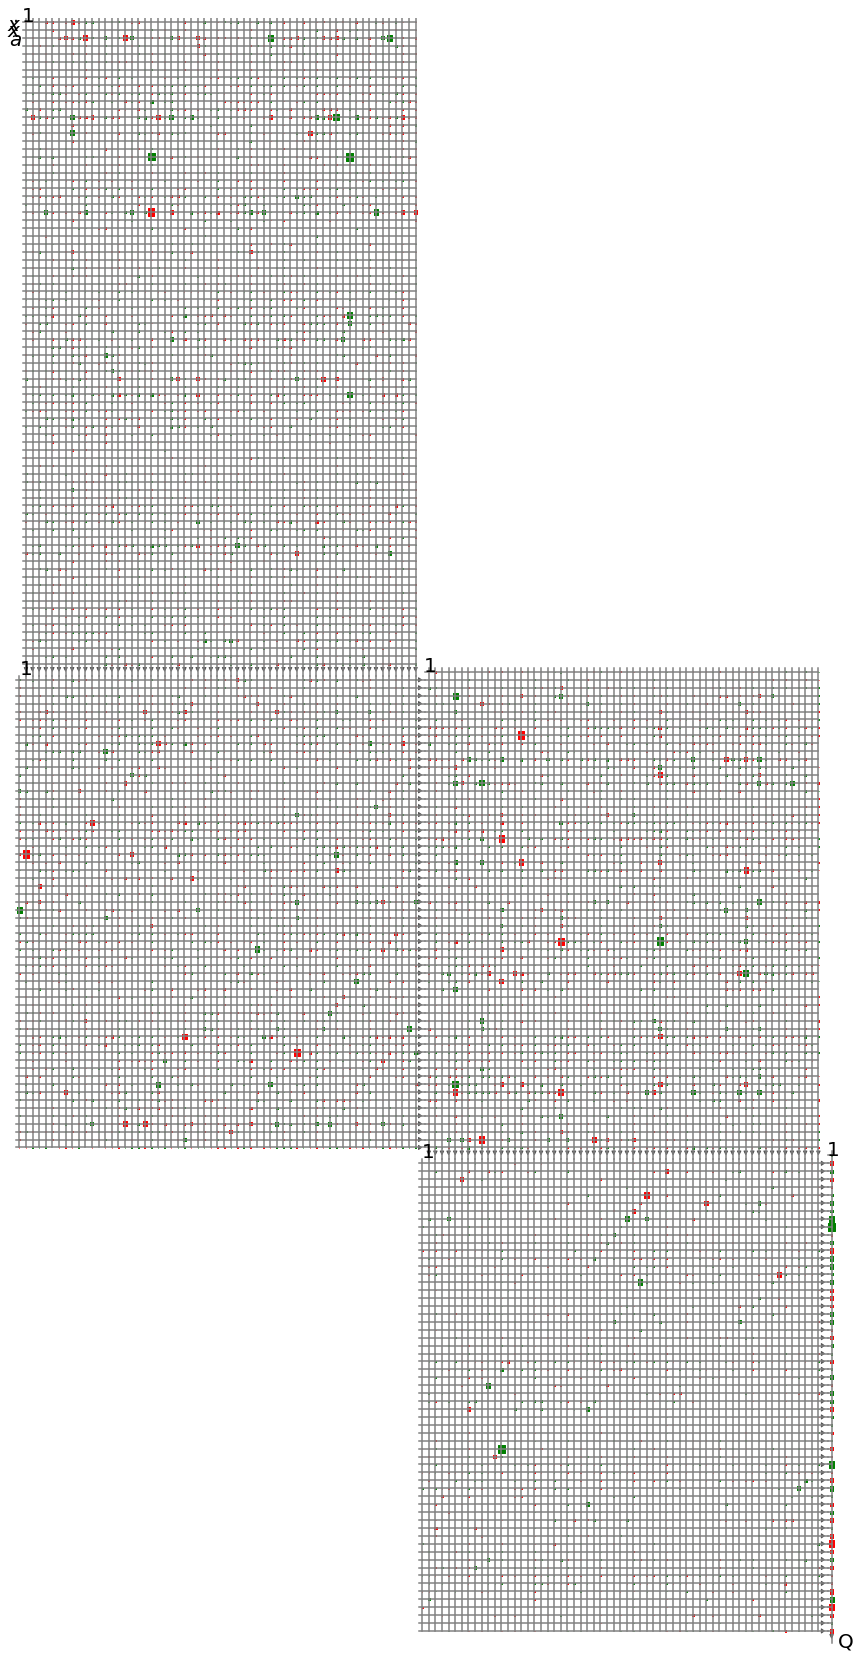

In [41]:
fig = plt.figure(figsize=(15, 30))
nnet_extra.draw(['$x$', '$\dot{x}$', '$a$'], ['Q'])

# Scikit Random Forest Regression

Although the previous methods achieved an accuracy higher than baseline, they were not able to predict the correct temperature in most of the cases. Despite repeated runs with various parameters, the previous methods did not improve significantly with the exception of ADAM, which showed the most improvement with parameter optimization.

It was hypothesized that Random Forest Regression would achieve higher performance than the previous methods on this data set because it would be able to generalize the data more effectively. This is because the RFR technique trains a single decision tree with every pass of the data. Additionally, each tree is trained on different parameters such that each tree is not correlated with the other trees. This produces n_estimators amount of trees with different decision making paths. The RFR then combines the trees to produce a forest of decision paths.

This technique achieved a higher accuracy than all the previous neural network techniques and took about as long to train.

In [42]:
from sklearn.ensemble import RandomForestRegressor

In [43]:
rfr = RandomForestRegressor(n_estimators = 2000, random_state = 50)

In [44]:
start_time = time.time()
rfr.fit(Xtrain_SuperCond, Ttrain_SuperCond.reshape(-1));
end_time = time.time()

print('Training took ', end_time-start_time, '  seconds.' )

Training took  1343.3600962162018   seconds.


In [45]:
# Use the forest's predict method on the test data
Y = rfr.predict(Xtest_SuperCond)
Y

array([57.05332583,  6.81698508, 33.25621511, ...,  2.94501667,
        8.91658615, 43.87254604])

In [46]:
Y = Y.reshape(-1, 1)
Y

array([[57.05332583],
       [ 6.81698508],
       [33.25621511],
       ...,
       [ 2.94501667],
       [ 8.91658615],
       [43.87254604]])

In [47]:
Ttest_SuperCond

array([[71.  ],
       [ 7.1 ],
       [33.2 ],
       ...,
       [ 2.9 ],
       [ 9.67],
       [38.  ]])

In [48]:
errors = abs(Y - Ttest_SuperCond)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
n_correct = ((abs(Y - Ttest_SuperCond) < (Ttest_SuperCond/10.))).sum()
print(f'{n_correct} out of {Ttest_SuperCond.shape[0]} samples, or {n_correct/Ttest_SuperCond.shape[0]*100:.2f} percent.')

Mean Absolute Error: 5.25 degrees.
1923 out of 4253 samples, or 45.22 percent.


In [49]:
errors = abs(Y - Ttest_SuperCond)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
n_correct = ((abs(Y - Ttest_SuperCond) < (Ttest_SuperCond/20.))).sum()
print(f'{n_correct} out of {Ttest_SuperCond.shape[0]} samples, or {n_correct/Ttest_SuperCond.shape[0]*100:.2f} percent.')

Mean Absolute Error: 5.25 degrees.
1185 out of 4253 samples, or 27.86 percent.


In [50]:
Ttest_SuperCond

array([[71.  ],
       [ 7.1 ],
       [33.2 ],
       ...,
       [ 2.9 ],
       [ 9.67],
       [38.  ]])

The folowing code uses the built in feature importances variable of the scikit toolkits to see which variables had the largest effect on training.

In [51]:
importances = list(rfr.feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(Xnames_SuperCond, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: range_ThermalConductivity Importance: 0.54
Variable: wtd_gmean_ThermalConductivity Importance: 0.13
Variable: std_atomic_mass      Importance: 0.02
Variable: wtd_gmean_Valence    Importance: 0.02
Variable: wtd_mean_atomic_mass Importance: 0.01
Variable: wtd_range_atomic_mass Importance: 0.01
Variable: wtd_std_atomic_mass  Importance: 0.01
Variable: wtd_range_fie        Importance: 0.01
Variable: range_atomic_radius  Importance: 0.01
Variable: std_atomic_radius    Importance: 0.01
Variable: wtd_std_atomic_radius Importance: 0.01
Variable: mean_Density         Importance: 0.01
Variable: entropy_Density      Importance: 0.01
Variable: wtd_entropy_Density  Importance: 0.01
Variable: std_Density          Importance: 0.01
Variable: gmean_ElectronAffinity Importance: 0.01
Variable: wtd_entropy_ElectronAffinity Importance: 0.01
Variable: wtd_range_ElectronAffinity Importance: 0.01
Variable: wtd_std_ElectronAffinity Importance: 0.01
Variable: wtd_entropy_FusionHeat Importance: 0.01
Va

From the summary above it is clear that only the top two variables have a significant effect on correctly predicting the target temperature. Not only that, but the outputs of this data set are not closely related to most of the inputs. This means that it will be difficult for any of the methods to achieve a 90% or greater accuracy. 

It is possible however, that another technique might yield more insight into this data set.

# Scikit Gradient Boost Regression

Unlike RFR, Gradient Boost Regression does not train each of its 'trees' separately. The error of one tree is passed onto the next tree, producing a gradient that gets progressively better. While GBR did not achieve the accuracy of RFR, it trained very quickly.

The lower accuracy of GBR is explained by the small correlation between the inputs and the outputs in the data. The most correlated variable only acounts for around 50% of the total variance between the outputs. This means that since GBR's estimators are closely related to eachother, they will develop a higher bias.

In [52]:
from sklearn.ensemble import GradientBoostingRegressor

In [53]:
gbr = GradientBoostingRegressor(n_estimators = 2000, random_state = 50)

In [54]:
start_time = time.time()

gbr.fit(Xtrain_SuperCondS, Ttrain_SuperCond.reshape(-1));
end_time = time.time()

print('Training took ', end_time-start_time, '  seconds.' )

Training took  193.58801174163818   seconds.


In [55]:
# Use the forest's predict method on the test data
Y = gbr.predict(Xtest_SuperCondS)
Y

array([55.11242052,  7.3056476 , 45.02429918, ...,  2.43139592,
        8.21957265, 39.64839422])

In [56]:
Y = Y.reshape(-1, 1)
Y

array([[55.11242052],
       [ 7.3056476 ],
       [45.02429918],
       ...,
       [ 2.43139592],
       [ 8.21957265],
       [39.64839422]])

In [57]:
Ttest_SuperCond

array([[71.  ],
       [ 7.1 ],
       [33.2 ],
       ...,
       [ 2.9 ],
       [ 9.67],
       [38.  ]])

In [58]:
errors = abs(Y - Ttest_SuperCond)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
n_correct = ((abs(Y - Ttest_SuperCond) < (Ttest_SuperCond/10.))).sum()
print(f'{n_correct} out of {Ttest_SuperCond.shape[0]} samples, or {n_correct/Ttest_SuperCond.shape[0]*100:.2f} percent.')

Mean Absolute Error: 5.98 degrees.
1421 out of 4253 samples, or 33.41 percent.


In [59]:
errors = abs(Y - Ttest_SuperCond)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
n_correct = ((abs(Y - Ttest_SuperCond) < (Ttest_SuperCond/20.))).sum()
print(f'{n_correct} out of {Ttest_SuperCond.shape[0]} samples, or {n_correct/Ttest_SuperCond.shape[0]*100:.2f} percent.')

Mean Absolute Error: 5.98 degrees.
783 out of 4253 samples, or 18.41 percent.


In [60]:
importances = list(gbr.feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(Xnames_SuperCond, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: range_ThermalConductivity Importance: 0.42
Variable: range_atomic_radius  Importance: 0.1
Variable: wtd_gmean_ThermalConductivity Importance: 0.08
Variable: wtd_mean_ThermalConductivity Importance: 0.03
Variable: wtd_std_ThermalConductivity Importance: 0.03
Variable: wtd_gmean_Valence    Importance: 0.03
Variable: std_atomic_mass      Importance: 0.02
Variable: wtd_std_ElectronAffinity Importance: 0.02
Variable: wtd_entropy_ThermalConductivity Importance: 0.02
Variable: wtd_mean_Valence     Importance: 0.02
Variable: wtd_mean_atomic_mass Importance: 0.01
Variable: wtd_range_fie        Importance: 0.01
Variable: wtd_std_atomic_radius Importance: 0.01
Variable: mean_Density         Importance: 0.01
Variable: gmean_Density        Importance: 0.01
Variable: wtd_entropy_Density  Importance: 0.01
Variable: std_Density          Importance: 0.01
Variable: wtd_gmean_ElectronAffinity Importance: 0.01
Variable: wtd_entropy_ElectronAffinity Importance: 0.01
Variable: std_ElectronAffinity

The range_thermalConductivity variable seems to account for most of the variance in the data set in the case of GBR as well. This means that models should be weighing that variable more heavily than the others.

# Scikit Nearest Neighbors Regression

Nearest neighbors regression achieved the best performance of all the networks in both speed and accuracy. Although it did not achieve a 90% or higher accuracy in these runs, it finished in seconds as compared to several minutes like the other methods. It was of interest to figure out why this method was so fast and accurate at the same time. 

## Uniform Weights

Uniform weights nearest neighbors will store the list of nearest neighbors, but will not sort them in order of relevance. Since only one variable accounts for most of the variance, it is likely this uniform weights will not be too adversely affected. Still, it is expected that uniform weights will perform worse than euclidian distance weights since each variable accounts for a different percentage of the variance.

In [61]:
from sklearn.neighbors import KNeighborsRegressor

In [62]:
knr = KNeighborsRegressor(n_neighbors=2, weights='uniform')

In [63]:
start_time = time.time()
knr.fit(Xtrain_SuperCondS, Ttrain_SuperCond.reshape(-1));
end_time = time.time()
print('Training took ', end_time-start_time, '  seconds.')

Training took  0.08588719367980957   seconds.


In [64]:
# Use the forest's predict method on the test data
Y = knr.predict(Xtest_SuperCondS)
Y

array([60.75 ,  7.8  , 30.65 , ...,  2.95 ,  9.205, 32.4  ])

In [65]:
Y = Y.reshape(-1, 1)
Y

array([[60.75 ],
       [ 7.8  ],
       [30.65 ],
       ...,
       [ 2.95 ],
       [ 9.205],
       [32.4  ]])

In [66]:
Ttest_SuperCond

array([[71.  ],
       [ 7.1 ],
       [33.2 ],
       ...,
       [ 2.9 ],
       [ 9.67],
       [38.  ]])

In [67]:
errors = abs(Y - Ttest_SuperCond)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
n_correct = ((abs(Y - Ttest_SuperCond) < (Ttest_SuperCond/10.))).sum()
print(f'{n_correct} out of {Ttest_SuperCond.shape[0]} samples, or {n_correct/Ttest_SuperCond.shape[0]*100:.2f} percent.')

Mean Absolute Error: 5.61 degrees.
1918 out of 4253 samples, or 45.10 percent.


In [68]:
errors = abs(Y - Ttest_SuperCond)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
n_correct = ((abs(Y - Ttest_SuperCond) < (Ttest_SuperCond/20.))).sum()
print(f'{n_correct} out of {Ttest_SuperCond.shape[0]} samples, or {n_correct/Ttest_SuperCond.shape[0]*100:.2f} percent.')

Mean Absolute Error: 5.61 degrees.
1278 out of 4253 samples, or 30.05 percent.


## Distance Weights

Distance weights uses the euclidian distance between the points of the inputs to deduce similarities. This means the model will predict temperature based on which inputs cluster together.

In [69]:
knr = KNeighborsRegressor(n_neighbors=2, weights='distance')

In [70]:
start_time = time.time()
knr.fit(Xtrain_SuperCond, Ttrain_SuperCond.reshape(-1));
end_time = time.time()
print('Training took ', end_time-start_time, '  seconds.' )

Training took  0.23325634002685547   seconds.


In [71]:
Y = knr.predict(Xtest_SuperCond)
Y

array([60.        ,  6.96106187, 30.62206153, ...,  2.94927614,
        9.21      , 38.92231042])

In [72]:
Y = Y.reshape(-1, 1)
Y

array([[60.        ],
       [ 6.96106187],
       [30.62206153],
       ...,
       [ 2.94927614],
       [ 9.21      ],
       [38.92231042]])

In [73]:
Ttest_SuperCond

array([[71.  ],
       [ 7.1 ],
       [33.2 ],
       ...,
       [ 2.9 ],
       [ 9.67],
       [38.  ]])

In [74]:
errors = abs(Y - Ttest_SuperCond)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
n_correct = ((abs(Y - Ttest_SuperCond) < (Ttest_SuperCond/10.))).sum()
print(f'{n_correct} out of {Ttest_SuperCond.shape[0]} samples, or {n_correct/Ttest_SuperCond.shape[0]*100:.2f} percent.')

Mean Absolute Error: 5.78 degrees.
1900 out of 4253 samples, or 44.67 percent.


In [75]:
errors = abs(Y - Ttest_SuperCond)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
n_correct = ((abs(Y - Ttest_SuperCond) < (Ttest_SuperCond/20.))).sum()
print(f'{n_correct} out of {Ttest_SuperCond.shape[0]} samples, or {n_correct/Ttest_SuperCond.shape[0]*100:.2f} percent.')

Mean Absolute Error: 5.78 degrees.
1320 out of 4253 samples, or 31.04 percent.


# Scikit Support Vector Machine Regression

Support vector machines took too long to train on the data when using the polynomial kernel and did not produce results after 24 hours of running. The polynomial kernel was desired since it would model the data better than a linear model. As expected, the radial basis function did not perform as well as previous methods, but it was at least able to finish the training within a minute. After reading about SVMs, it is understood that data sets with too many dimensions (inputs) and samples will cause SVM to perform poorly and take days to train. 

In [76]:
from sklearn import svm

In [77]:
supvec = svm.SVR(kernel='rbf', C=10, gamma='auto', epsilon=.1, coef0=1)

In [78]:
supvec.fit(Xtrain_SuperCond, Ttrain_SuperCond.reshape(-1))

SVR(C=10, cache_size=200, coef0=1, degree=3, epsilon=0.1, gamma='auto',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [79]:
# Use the forest's predict method on the test data
Y = supvec.predict(Xtest_SuperCond)
Y

array([30.49158738, 20.49158738, 20.49158738, ..., 20.49085114,
        9.16023575, 25.77420755])

In [80]:
Y = Y.reshape(-1, 1)
Y

array([[30.49158738],
       [20.49158738],
       [20.49158738],
       ...,
       [20.49085114],
       [ 9.16023575],
       [25.77420755]])

In [81]:
Ttest_SuperCond

array([[71.  ],
       [ 7.1 ],
       [33.2 ],
       ...,
       [ 2.9 ],
       [ 9.67],
       [38.  ]])

In [82]:
errors = abs(Y - Ttest_SuperCond)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
n_correct = ((abs(Y - Ttest_SuperCond) < (Ttest_SuperCond/10.))).sum()
print(f'{n_correct} out of {Ttest_SuperCond.shape[0]} samples, or {n_correct/Ttest_SuperCond.shape[0]*100:.2f} percent.')

Mean Absolute Error: 18.9 degrees.
783 out of 4253 samples, or 18.41 percent.


In [83]:
errors = abs(Y - Ttest_SuperCond)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
n_correct = ((abs(Y - Ttest_SuperCond) < (Ttest_SuperCond/20.))).sum()
print(f'{n_correct} out of {Ttest_SuperCond.shape[0]} samples, or {n_correct/Ttest_SuperCond.shape[0]*100:.2f} percent.')

Mean Absolute Error: 18.9 degrees.
528 out of 4253 samples, or 12.41 percent.


# Scikit Dimensional Reduction

From readings it was understood that dimensional reduction would be beneficial to systems using many inputs. It was not clear however, that the dimensional reduction technique could be used in combination with other technqiues previously used. Dimensional reduction seemed to greatly boost the speed of the random forest technique and slightly boost the performance. However, dimensional reduction worsened the accuracy of the K nearest neighbors approach and did not boost its accuracy.

The scikit libraries contain several forms of dimensional reduction but since dimensional reduction was not the focus of this effort and a significant performance gap was not found between the different methods only two are shown. 

The first dimensional reduction technique is principal component analysis. This technique uses a mathematical orthogonal transformation to determine which of the variables accounts for the largest amount of variance in the output. It is important to note that this technique does not treat each variable as independent from the others.

The second one is independent component analysis. This technique separates each variable and studies which one has the largest effect on the output signal. This technique treats each input as an independent variable. 

In [84]:
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NeighborhoodComponentsAnalysis

In [85]:
random_state = 0

pca = PCA(n_components=3)
pca.fit(Xtrain_SuperCondS, Ttrain_SuperCond)

ica = FastICA(n_components=3)
ica.fit(Xtrain_SuperCondS, Ttrain_SuperCond)

FastICA(algorithm='parallel', fun='logcosh', fun_args=None, max_iter=200,
        n_components=3, random_state=None, tol=0.0001, w_init=None,
        whiten=True)

## Nearest Neighbors Reduced

Nearest neighbors did not run any faster with dimensional reduction. The accuracy decreased.

In [86]:
knr = KNeighborsRegressor(n_neighbors=2, weights='distance')

In [87]:
start_time = time.time()
knr.fit(pca.transform(Xtrain_SuperCondS), Ttrain_SuperCond)
end_time = time.time()
print('Training took ', end_time-start_time, '  seconds.' )

Training took  0.023835420608520508   seconds.


In [88]:
# Use the forest's predict method on the test data
Y = knr.predict(pca.transform(Xtest_SuperCondS))
Y

array([[60.        ],
       [ 9.45236671],
       [30.64662312],
       ...,
       [ 2.94640269],
       [ 9.23      ],
       [43.59455294]])

In [89]:
Y = Y.reshape(-1, 1)
Y

array([[60.        ],
       [ 9.45236671],
       [30.64662312],
       ...,
       [ 2.94640269],
       [ 9.23      ],
       [43.59455294]])

In [90]:
Ttest_SuperCond

array([[71.  ],
       [ 7.1 ],
       [33.2 ],
       ...,
       [ 2.9 ],
       [ 9.67],
       [38.  ]])

In [91]:
errors = abs(Y - Ttest_SuperCond)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
n_correct = ((abs(Y - Ttest_SuperCond) < (Ttest_SuperCond/10.))).sum()
print(f'{n_correct} out of {Ttest_SuperCond.shape[0]} samples, or {n_correct/Ttest_SuperCond.shape[0]*100:.2f} percent.')

Mean Absolute Error: 7.16 degrees.
1721 out of 4253 samples, or 40.47 percent.


In [92]:
errors = abs(Y - Ttest_SuperCond)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
n_correct = ((abs(Y - Ttest_SuperCond) < (Ttest_SuperCond/20.))).sum()
print(f'{n_correct} out of {Ttest_SuperCond.shape[0]} samples, or {n_correct/Ttest_SuperCond.shape[0]*100:.2f} percent.')

Mean Absolute Error: 7.16 degrees.
1196 out of 4253 samples, or 28.12 percent.


In [93]:
start_time = time.time()
knr.fit(ica.transform(Xtrain_SuperCondS), Ttrain_SuperCond)
end_time = time.time()
print('Training took ', end_time-start_time, '  seconds.' )

Training took  0.024810314178466797   seconds.


In [94]:
# Use the forest's predict method on the test data
Y = knr.predict(ica.transform(Xtest_SuperCondS))
Y

array([[60.        ],
       [ 9.38733084],
       [30.65519103],
       ...,
       [ 2.94652346],
       [ 8.75      ],
       [43.8160935 ]])

In [95]:
Y = Y.reshape(-1, 1)
Y

array([[60.        ],
       [ 9.38733084],
       [30.65519103],
       ...,
       [ 2.94652346],
       [ 8.75      ],
       [43.8160935 ]])

In [96]:
Ttest_SuperCond

array([[71.  ],
       [ 7.1 ],
       [33.2 ],
       ...,
       [ 2.9 ],
       [ 9.67],
       [38.  ]])

In [97]:
errors = abs(Y - Ttest_SuperCond)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
n_correct = ((abs(Y - Ttest_SuperCond) < (Ttest_SuperCond/10.))).sum()
print(f'{n_correct} out of {Ttest_SuperCond.shape[0]} samples, or {n_correct/Ttest_SuperCond.shape[0]*100:.2f} percent.')

Mean Absolute Error: 7.2 degrees.
1744 out of 4253 samples, or 41.01 percent.


In [98]:
errors = abs(Y - Ttest_SuperCond)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
n_correct = ((abs(Y - Ttest_SuperCond) < (Ttest_SuperCond/20.))).sum()
print(f'{n_correct} out of {Ttest_SuperCond.shape[0]} samples, or {n_correct/Ttest_SuperCond.shape[0]*100:.2f} percent.')

Mean Absolute Error: 7.2 degrees.
1208 out of 4253 samples, or 28.40 percent.


## Random Forest Reduced

With dimensional reduction the training time for random forests decreased significantly with only a small decrease in accuracy. It is likely that some variables account for a greater amount of variance than the model believes.

In [99]:
rfr = RandomForestRegressor(n_estimators = 2000, random_state = 50)

In [100]:
start_time = time.time()
rfr.fit(pca.transform(Xtrain_SuperCondS), Ttrain_SuperCond)
end_time = time.time()
print('Training took ', end_time-start_time, '  seconds.' )

/home/rodozor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


Training took  78.37719893455505   seconds.


In [101]:
# Use the forest's predict method on the test data
Y = rfr.predict(pca.transform(Xtest_SuperCondS))
Y

array([55.03922433,  8.866731  , 57.706645  , ...,  2.94600083,
        8.91284115, 40.73457353])

In [102]:
Y = Y.reshape(-1, 1)
Y

array([[55.03922433],
       [ 8.866731  ],
       [57.706645  ],
       ...,
       [ 2.94600083],
       [ 8.91284115],
       [40.73457353]])

In [103]:
Ttest_SuperCond

array([[71.  ],
       [ 7.1 ],
       [33.2 ],
       ...,
       [ 2.9 ],
       [ 9.67],
       [38.  ]])

In [104]:
errors = abs(Y - Ttest_SuperCond)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
n_correct = ((abs(Y - Ttest_SuperCond) < (Ttest_SuperCond/10.))).sum()
print(f'{n_correct} out of {Ttest_SuperCond.shape[0]} samples, or {n_correct/Ttest_SuperCond.shape[0]*100:.2f} percent.')

Mean Absolute Error: 7.78 degrees.
1483 out of 4253 samples, or 34.87 percent.


In [105]:
errors = abs(Y - Ttest_SuperCond)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
n_correct = ((abs(Y - Ttest_SuperCond) < (Ttest_SuperCond/20.))).sum()
print(f'{n_correct} out of {Ttest_SuperCond.shape[0]} samples, or {n_correct/Ttest_SuperCond.shape[0]*100:.2f} percent.')

Mean Absolute Error: 7.78 degrees.
851 out of 4253 samples, or 20.01 percent.


In [106]:
start_time = time.time()
rfr.fit(ica.transform(Xtrain_SuperCondS), Ttrain_SuperCond)
end_time = time.time()
print('Training took ', end_time-start_time, '  seconds.' )

/home/rodozor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


Training took  80.34303116798401   seconds.


In [107]:
importances = list(rfr.feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(Xnames_SuperCond, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: wtd_mean_atomic_mass Importance: 0.62
Variable: mean_atomic_mass     Importance: 0.24
Variable: number_of_elements   Importance: 0.15


In [108]:
Y = rfr.predict(ica.transform(Xtest_SuperCondS))
Y

array([52.4875969 ,  6.21812605, 46.42650845, ...,  3.64647833,
        8.91284115, 46.03573571])

In [109]:
Y = Y.reshape(-1, 1)
Y

array([[52.4875969 ],
       [ 6.21812605],
       [46.42650845],
       ...,
       [ 3.64647833],
       [ 8.91284115],
       [46.03573571]])

In [110]:
Ttest_SuperCond

array([[71.  ],
       [ 7.1 ],
       [33.2 ],
       ...,
       [ 2.9 ],
       [ 9.67],
       [38.  ]])

In [111]:
errors = abs(Y - Ttest_SuperCond)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
n_correct = ((abs(Y - Ttest_SuperCond) < (Ttest_SuperCond/10.))).sum()
print(f'{n_correct} out of {Ttest_SuperCond.shape[0]} samples, or {n_correct/Ttest_SuperCond.shape[0]*100:.2f} percent.')

Mean Absolute Error: 7.7 degrees.
1481 out of 4253 samples, or 34.82 percent.


In [112]:
errors = abs(Y - Ttest_SuperCond)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
n_correct = ((abs(Y - Ttest_SuperCond) < (Ttest_SuperCond/20.))).sum()
print(f'{n_correct} out of {Ttest_SuperCond.shape[0]} samples, or {n_correct/Ttest_SuperCond.shape[0]*100:.2f} percent.')

Mean Absolute Error: 7.7 degrees.
840 out of 4253 samples, or 19.75 percent.


In [113]:
importances = list(rfr.feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(Xnames_SuperCond, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: wtd_mean_atomic_mass Importance: 0.62
Variable: mean_atomic_mass     Importance: 0.24
Variable: number_of_elements   Importance: 0.15


## Support Vector Machine Reduced

It was of interest to see if the polynomial kernel for the SVM method would run faster with dimensional reduction. While the rbf did show a decrease in training time, the polynomial did not finish after 2 hours. Since predicting the super conductor temperature is a function of various inputs, it was anticipated that a polynomial function would achieve a high accuracy, but the long training times were not anticipated.

In [114]:
supvec = svm.SVR(kernel='rbf', C=10, gamma='auto', epsilon=.1, coef0=1)

In [115]:
start_time = time.time()
supvec.fit(pca.transform(Xtrain_SuperCondS), Ttrain_SuperCond.reshape(-1))
end_time = time.time()
print('Training took ', end_time-start_time, '  seconds.' )

Training took  16.20420002937317   seconds.


In [116]:
# Use the forest's predict method on the test data
Y = supvec.predict(pca.transform(Xtest_SuperCondS))
Y

array([55.53486719, 12.63295962, 45.05937687, ...,  2.65534173,
        4.01676202, 68.08651993])

In [117]:
Y = Y.reshape(-1, 1)
Y

array([[55.53486719],
       [12.63295962],
       [45.05937687],
       ...,
       [ 2.65534173],
       [ 4.01676202],
       [68.08651993]])

In [118]:
Ttest_SuperCond

array([[71.  ],
       [ 7.1 ],
       [33.2 ],
       ...,
       [ 2.9 ],
       [ 9.67],
       [38.  ]])

In [119]:
errors = abs(Y - Ttest_SuperCond)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
n_correct = ((abs(Y - Ttest_SuperCond) < (Ttest_SuperCond/10.))).sum()
print(f'{n_correct} out of {Ttest_SuperCond.shape[0]} samples, or {n_correct/Ttest_SuperCond.shape[0]*100:.2f} percent.')

Mean Absolute Error: 12.67 degrees.
844 out of 4253 samples, or 19.84 percent.


In [120]:
errors = abs(Y - Ttest_SuperCond)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
n_correct = ((abs(Y - Ttest_SuperCond) < (Ttest_SuperCond/20.))).sum()
print(f'{n_correct} out of {Ttest_SuperCond.shape[0]} samples, or {n_correct/Ttest_SuperCond.shape[0]*100:.2f} percent.')

Mean Absolute Error: 12.67 degrees.
433 out of 4253 samples, or 10.18 percent.


# Nearest Neighbors Regression Revisited

The performance of nearest neighbors can be explained by the low correlation between inputs and outputs for the super conductor data set. By increasing the neighbor count, it is anticipated that the performance will decrease because only the first variable correlates somewhat well with the outputs. The other variables do not correlate at all and only add noise to the data set. Because the data set is poorly correlated it is also anticipated that a brute force approach to the neihbor set will result in the best performance as opposed to decision trees on poorly correlated data.

In [121]:
results_knn = pd.DataFrame(columns=['Neighbor Count', 'Weight Function', 'Algorithm', 
                                    'Test Error', 'Percent Correct 5% Accuracy Test', 'Percent Correct 33% Accuracy Test',
                                    'Train Teror', 'Percent Correct 5% Accuracy Train', 'Percent Correct 33% Accuracy Train'])

for neighbor_count in range(1,8):
    for weight_func in ['distance', 'uniform']:
        for algo in ['auto', 'ball_tree', 'kd_tree', 'brute']:
            knr = KNeighborsRegressor(n_neighbors=neighbor_count, weights=weight_func, algorithm=algo)
            knr.fit(Xtrain_SuperCondS, Ttrain_SuperCond.reshape(-1));
            Y = knr.predict(Xtest_SuperCondS)
            Y = Y.reshape(-1, 1)

            errors = abs(Y - Ttest_SuperCond)
            n_correct_5 = ((abs(Y - Ttest_SuperCond) < (Ttest_SuperCond/20.))).sum()
            n_correct_33 = ((abs(Y - Ttest_SuperCond) < (Ttest_SuperCond/3.))).sum()
                        
            Y = knr.predict(Xtrain_SuperCondS)
            Y = Y.reshape(-1, 1)

            errors_train = abs(Y - Ttrain_SuperCond)
            n_correct_5_train = ((abs(Y - Ttrain_SuperCond) < (Ttrain_SuperCond/20.))).sum()
            n_correct_33_train= ((abs(Y - Ttrain_SuperCond) < (Ttrain_SuperCond/3.))).sum()
            
            results_knn.loc[len(results_knn)] = [neighbor_count, weight_func, algo, 
                                                 round(np.mean(errors), 2), n_correct_5/Ttest_SuperCond.shape[0]*100, n_correct_33/Ttest_SuperCond.shape[0]*100,
                                                 round(np.mean(errors_train), 2), n_correct_5_train/Ttrain_SuperCond.shape[0]*100, n_correct_33_train/Ttrain_SuperCond.shape[0]*100]          
       

In [122]:
results_knn = results_knn.sort_values('Percent Correct 5% Accuracy Test', ascending=False)
results_knn

,Neighbor Count,Weight Function,Algorithm,Test Error,Percent Correct 5% Accuracy Test,Percent Correct 33% Accuracy Test,Train Teror,Percent Correct 5% Accuracy Train,Percent Correct 33% Accuracy Train
9,2,distance,ball_tree,5.51,32.776863,76.158006,1.44,79.476778,95.479130
8,2,distance,auto,5.51,32.706325,76.205032,1.44,79.476778,95.479130
10,2,distance,kd_tree,5.51,32.706325,76.205032,1.44,79.476778,95.479130
11,2,distance,brute,5.57,32.518222,76.158006,1.00,86.161082,97.042916
3,1,distance,brute,5.94,32.024453,74.817776,1.07,88.559671,96.460905
7,1,uniform,brute,5.94,32.024453,74.841289,1.07,88.559671,96.460905
19,3,distance,brute,5.54,31.906889,76.534211,0.97,86.208113,97.136978
17,3,distance,ball_tree,5.49,31.812838,76.651775,1.39,79.223986,95.937684
18,3,distance,kd_tree,5.50,31.695274,76.651775,1.39,79.223986,95.937684
16,3,distance,auto,5.50,31.695274,76.651775,1.39,79.223986,95.937684


From the results, it looks like using the euclidian distance has a larger effect on the percent correct than any other parameter. Using uniform weights seems to lower performance by 5%.

Plotting every sample in the data set vs the predicted value resulted in a plot that was too difficult to read without downloading it and opening it in an image editor with the zoom function, so only every 20th sample is shown.

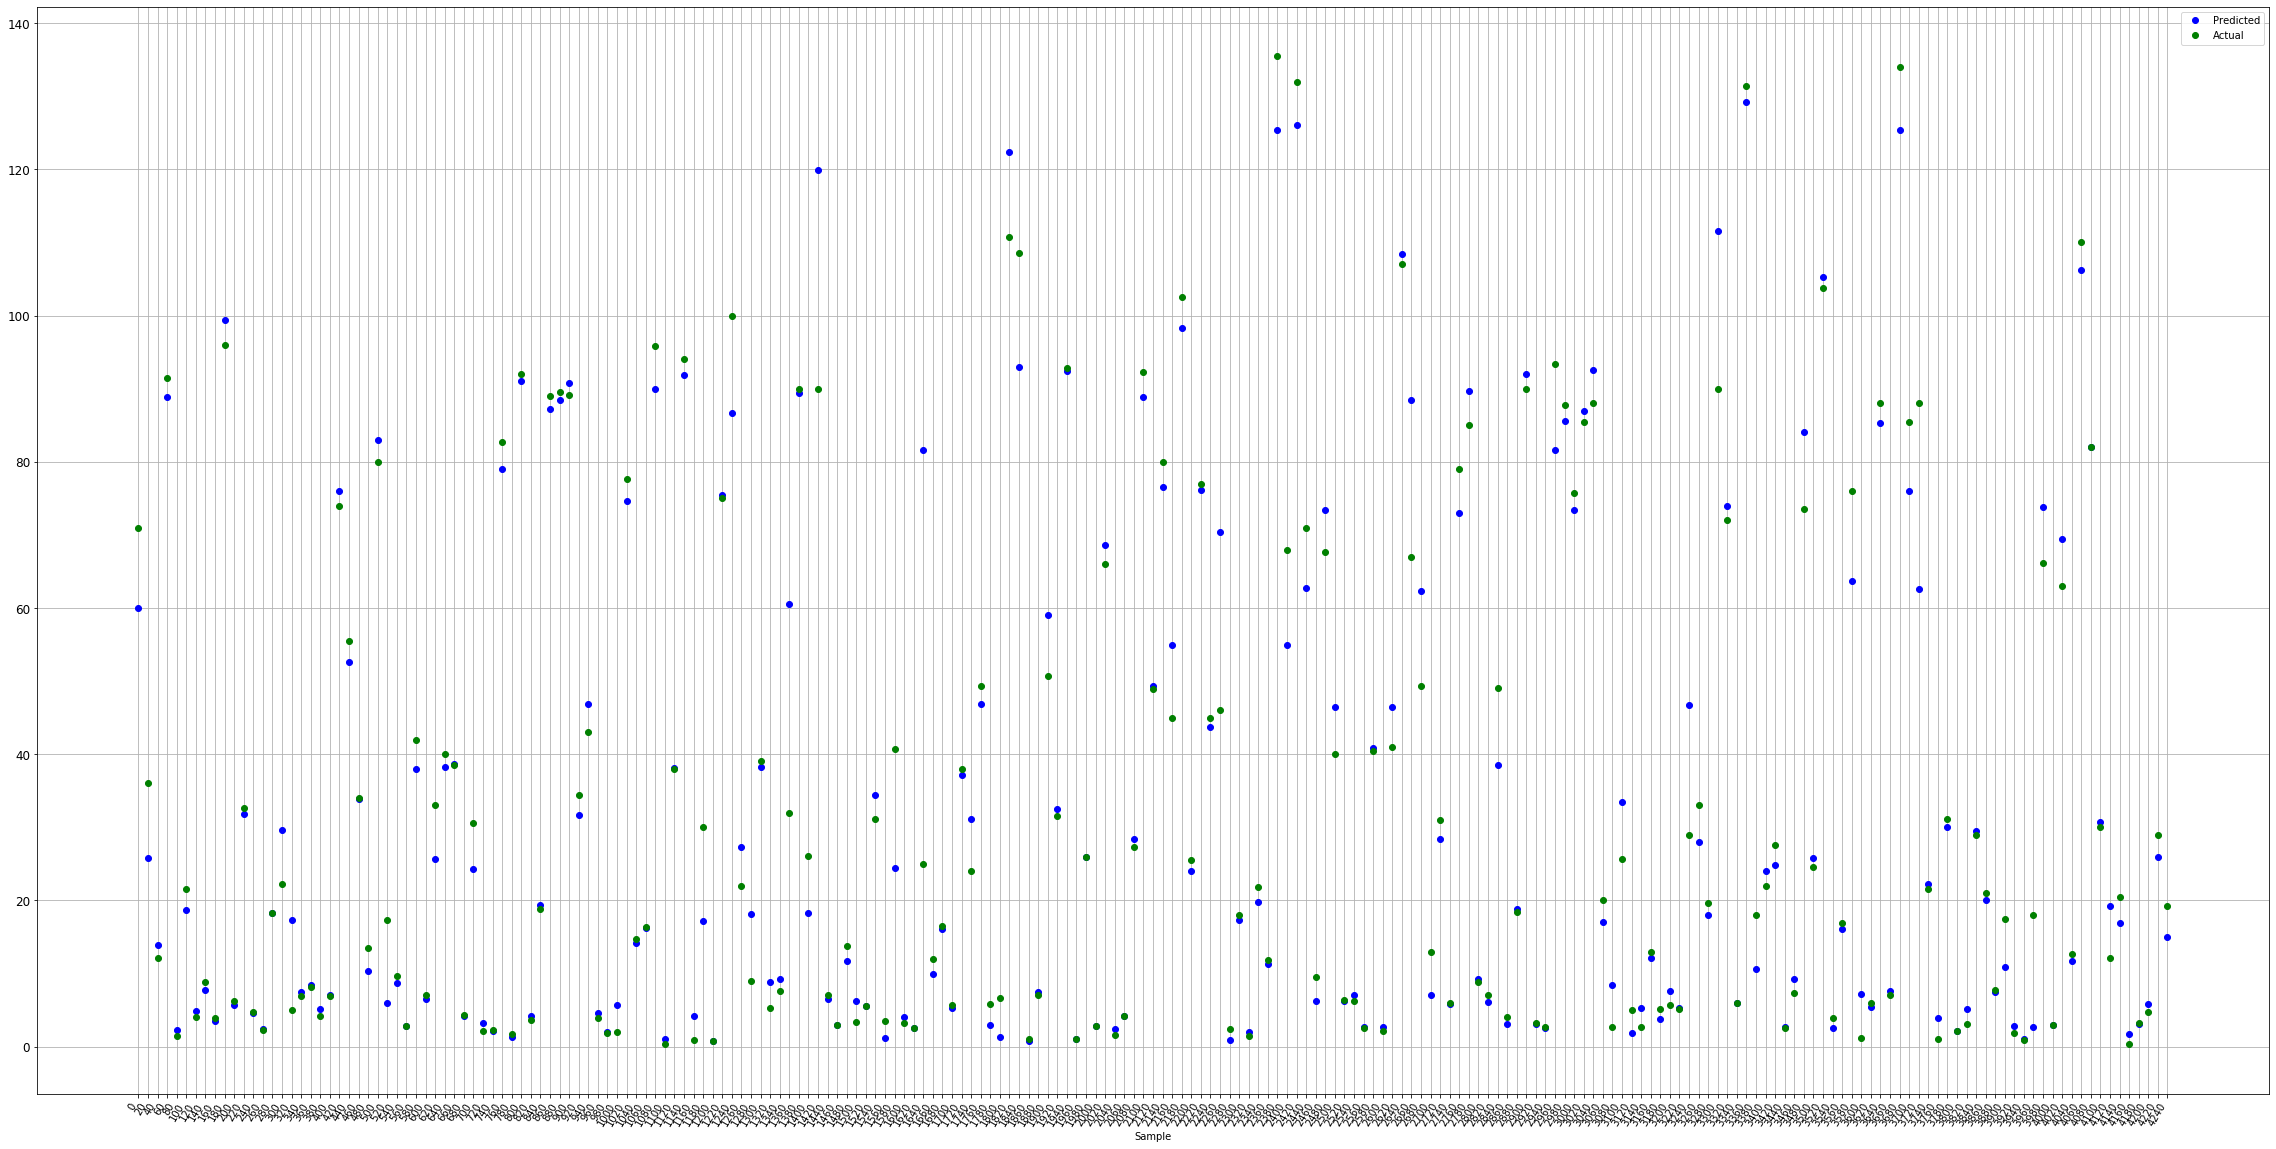

In [123]:
best_ncount = np.array(results_knn[['Neighbor Count']])
best_weightf= np.array(results_knn[['Weight Function']])[0]
best_algo   = np.array(results_knn[['Algorithm']])[0]

best_ncount = best_ncount[0][0]
best_weightf= best_weightf[0]
best_algo   = best_algo[0]

knr = KNeighborsRegressor(n_neighbors=best_ncount, weights=best_weightf, algorithm=best_algo)
knr.fit(Xtrain_SuperCondS, Ttrain_SuperCond.reshape(-1));
Y_test = knr.predict(Xtest_SuperCondS)
Y_test = Y_test.reshape(-1, 1)

n = 20

X = np.arange(0, Ttest_SuperCond.shape[0]).reshape(-1, 1)
plt.rc('xtick',labelsize=10)
plt.rc('ytick',labelsize=12)

plt.figure(figsize=(40, 20))
plt.plot(X[::n], Y_test[::n], 'bo', X[::n], Ttest_SuperCond[::n], 'go')
plt.legend(('Predicted', 'Actual'))
plt.xticks(X[::n], rotation=60, horizontalalignment='right')
plt.xlabel('Sample')
plt.grid(True)

For the training data, plot only every 80th sample.

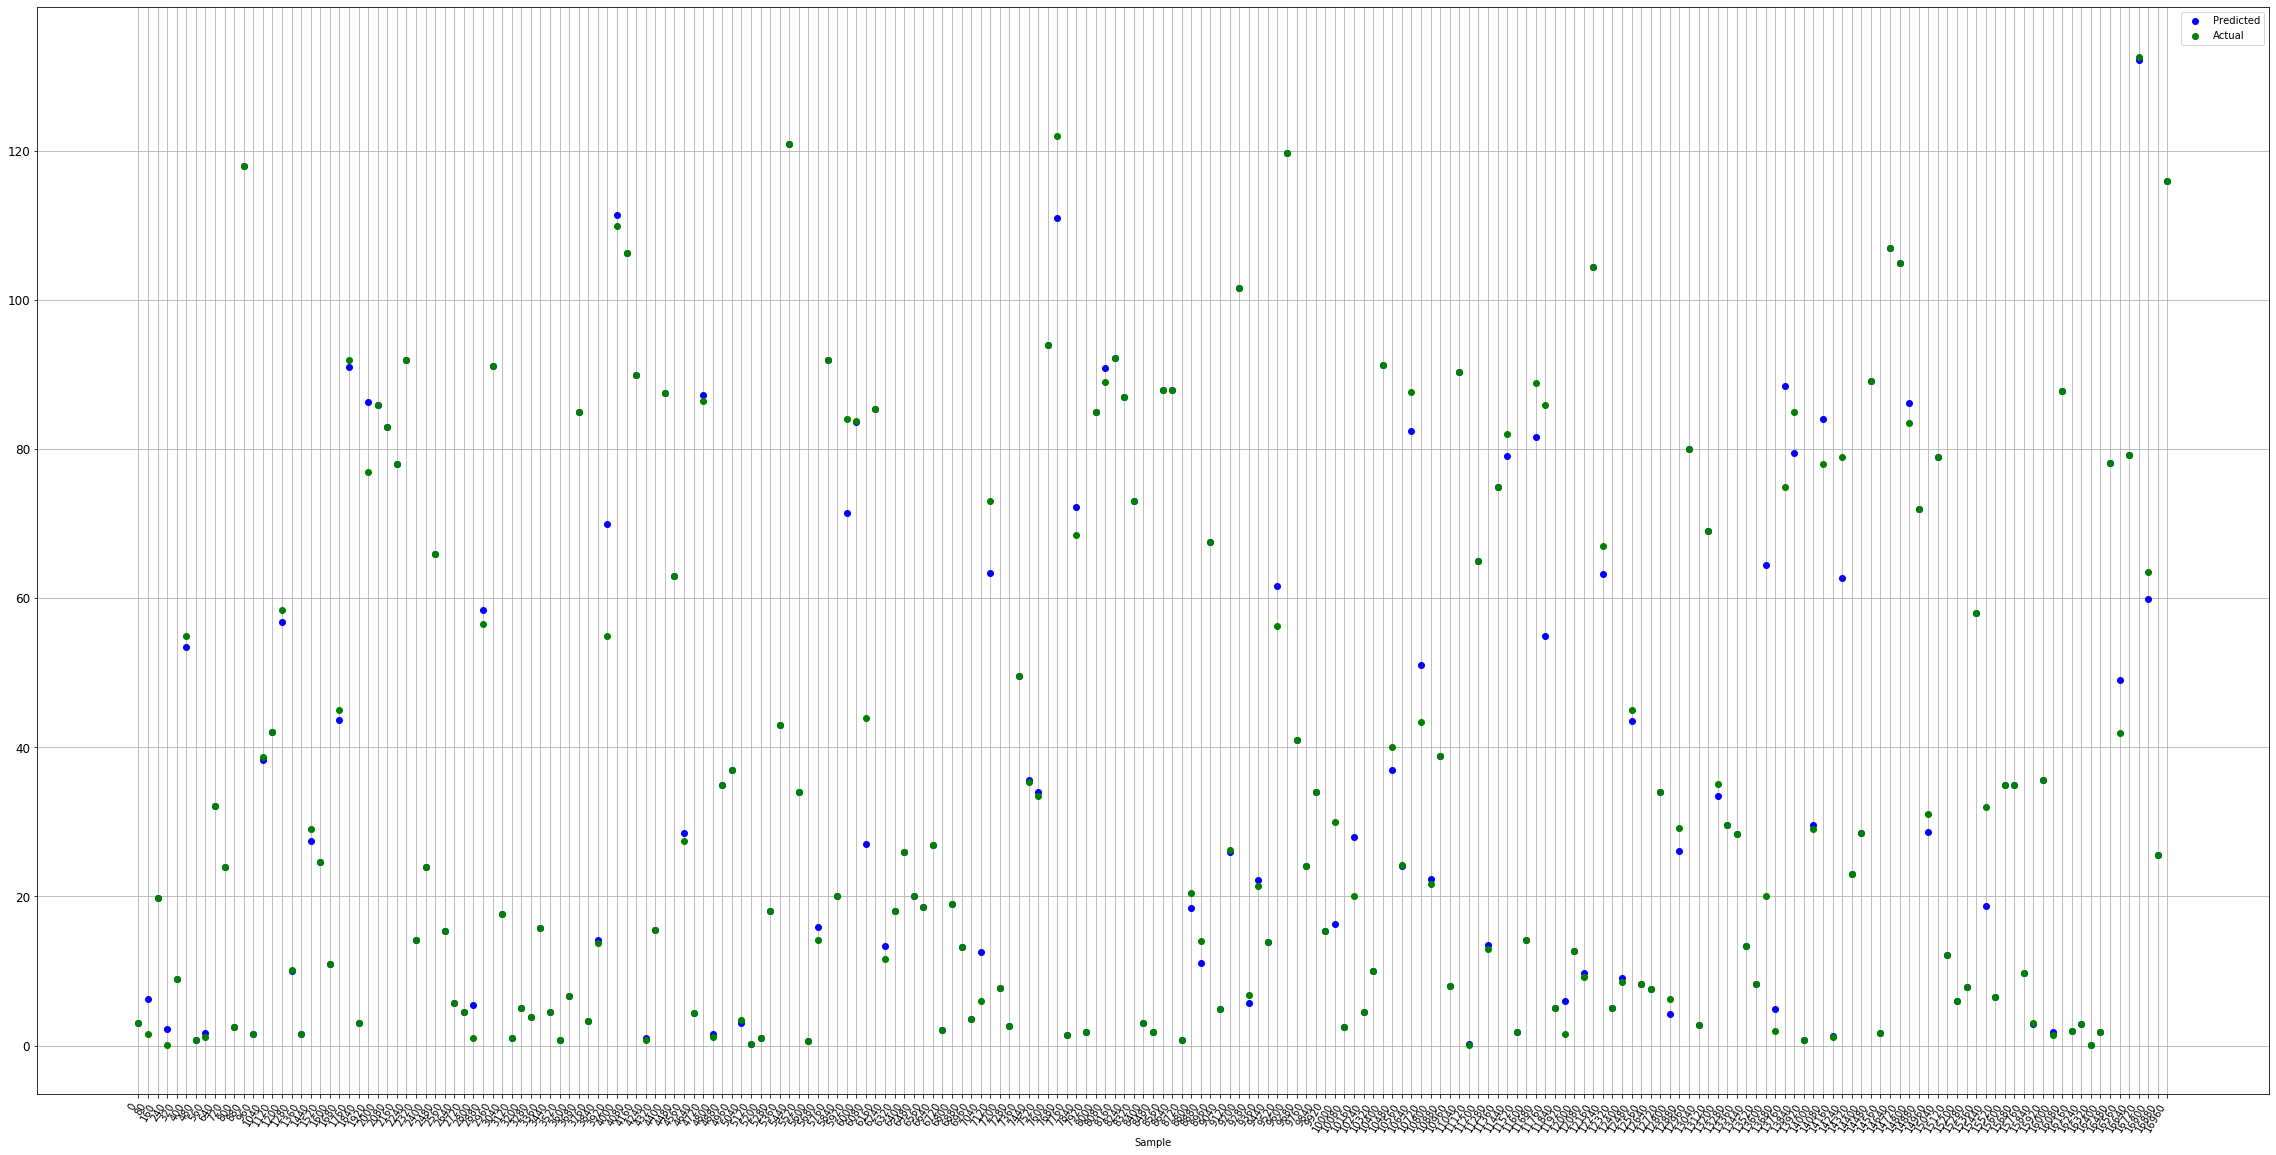

In [124]:
Y_train = knr.predict(Xtrain_SuperCondS)
Y_train = Y_train.reshape(-1, 1)

n = 80

X = np.arange(0, Ttrain_SuperCond.shape[0]).reshape(-1, 1)
plt.rc('xtick',labelsize=10)
plt.rc('ytick',labelsize=12)

plt.figure(figsize=(40, 20))
plt.plot(X[::n], Y_train[::n], 'bo', X[::n], Ttrain_SuperCond[::n], 'go')
plt.legend(('Predicted', 'Actual'))
plt.xticks(X[::n], rotation=60, horizontalalignment='right')
plt.xlabel('Sample')
plt.grid(True)

In [125]:
errors = abs(Y_test - Ttest_SuperCond)
n_correct = ((abs(Y_test - Ttest_SuperCond) < (Ttest_SuperCond/20.))).sum()

input_hi = 0
target_hi = 0
error_hi = 0

input_lo = 0
target_lo= 0
error_lo = 0
for i in range(len(Ttest_SuperCond)):
    error_cur = Y[i] - Ttest_SuperCond[i]
    if(error_cur > error_hi):
        error_hi = error_cur
        input_hi = Xtest_SuperCond[i]
        target_hi= Ttest_SuperCond[i]
    if(error_cur < error_lo):
        error_lo = error_cur
        input_lo = Xtest_SuperCond[i]
        target_lo= Ttest_SuperCond[i]
        
print('Most troublesome sample')
for i, val, nam in zip(range(len(input_hi)), input_hi, Xnames_SuperCond):
    print(i, ' ', nam, '\t\t', val)
print()
print('Least troublesome sample:')
for i, val, nam in zip(range(len(input_lo)), input_lo, Xnames_SuperCond):
    print(i, ' ', nam, '\t\t', val)

Most troublesome sample
0   number_of_elements 		 3.0
1   mean_atomic_mass 		 97.8903692
2   wtd_mean_atomic_mass 		 185.077425024
3   gmean_atomic_mass 		 71.825462669431
4   wtd_gmean_atomic_mass 		 174.509401633312
5   entropy_atomic_mass 		 0.828626616798764
6   wtd_entropy_atomic_mass 		 0.113896037622961
7   range_atomic_mass 		 169.9850304
8   wtd_range_atomic_mass 		 180.129981936
9   std_atomic_mass 		 72.1977753847446
10   wtd_std_atomic_mass 		 40.7686363764575
11   mean_fie 		 681.733333333333
12   wtd_mean_fie 		 864.392
13   gmean_fie 		 667.230718317456
14   wtd_gmean_fie 		 859.163109457106
15   entropy_fie 		 1.07637723982078
16   wtd_entropy_fie 		 0.24574089890649
17   range_fie 		 312.1
18   wtd_range_fie 		 795.068
19   std_fie 		 146.77307503611
20   wtd_std_fie 		 84.467403985206
21   mean_atomic_radius 		 142.666666666667
22   wtd_mean_atomic_radius 		 170.24
23   gmean_atomic_radius 		 140.817529670074
24   wtd_gmean_atomic_radius 		 169.637609972286
25   entro

From examining the data it seems that the samples that are more difficult to classify are those with a smaller value of range thermal conductivity. For the sample with the most error shown above, the thermal conductivty had a value of 61 while for the sample with the smallest error had a range thermal conductivity of almost 400. Since the range of thermal conductivity seems to be one of the more important values to the algorithms when determining temperature, a small range of thermal conductivity will make a sample more difficult to predict. 

In [126]:
range_thermals = Xtest_SuperCond[:,67].reshape(-1,1)
range_thermals

array([[399.97342],
       [143.     ],
       [399.97342],
       ...,
       [ 32.     ],
       [  8.     ],
       [399.97342]])

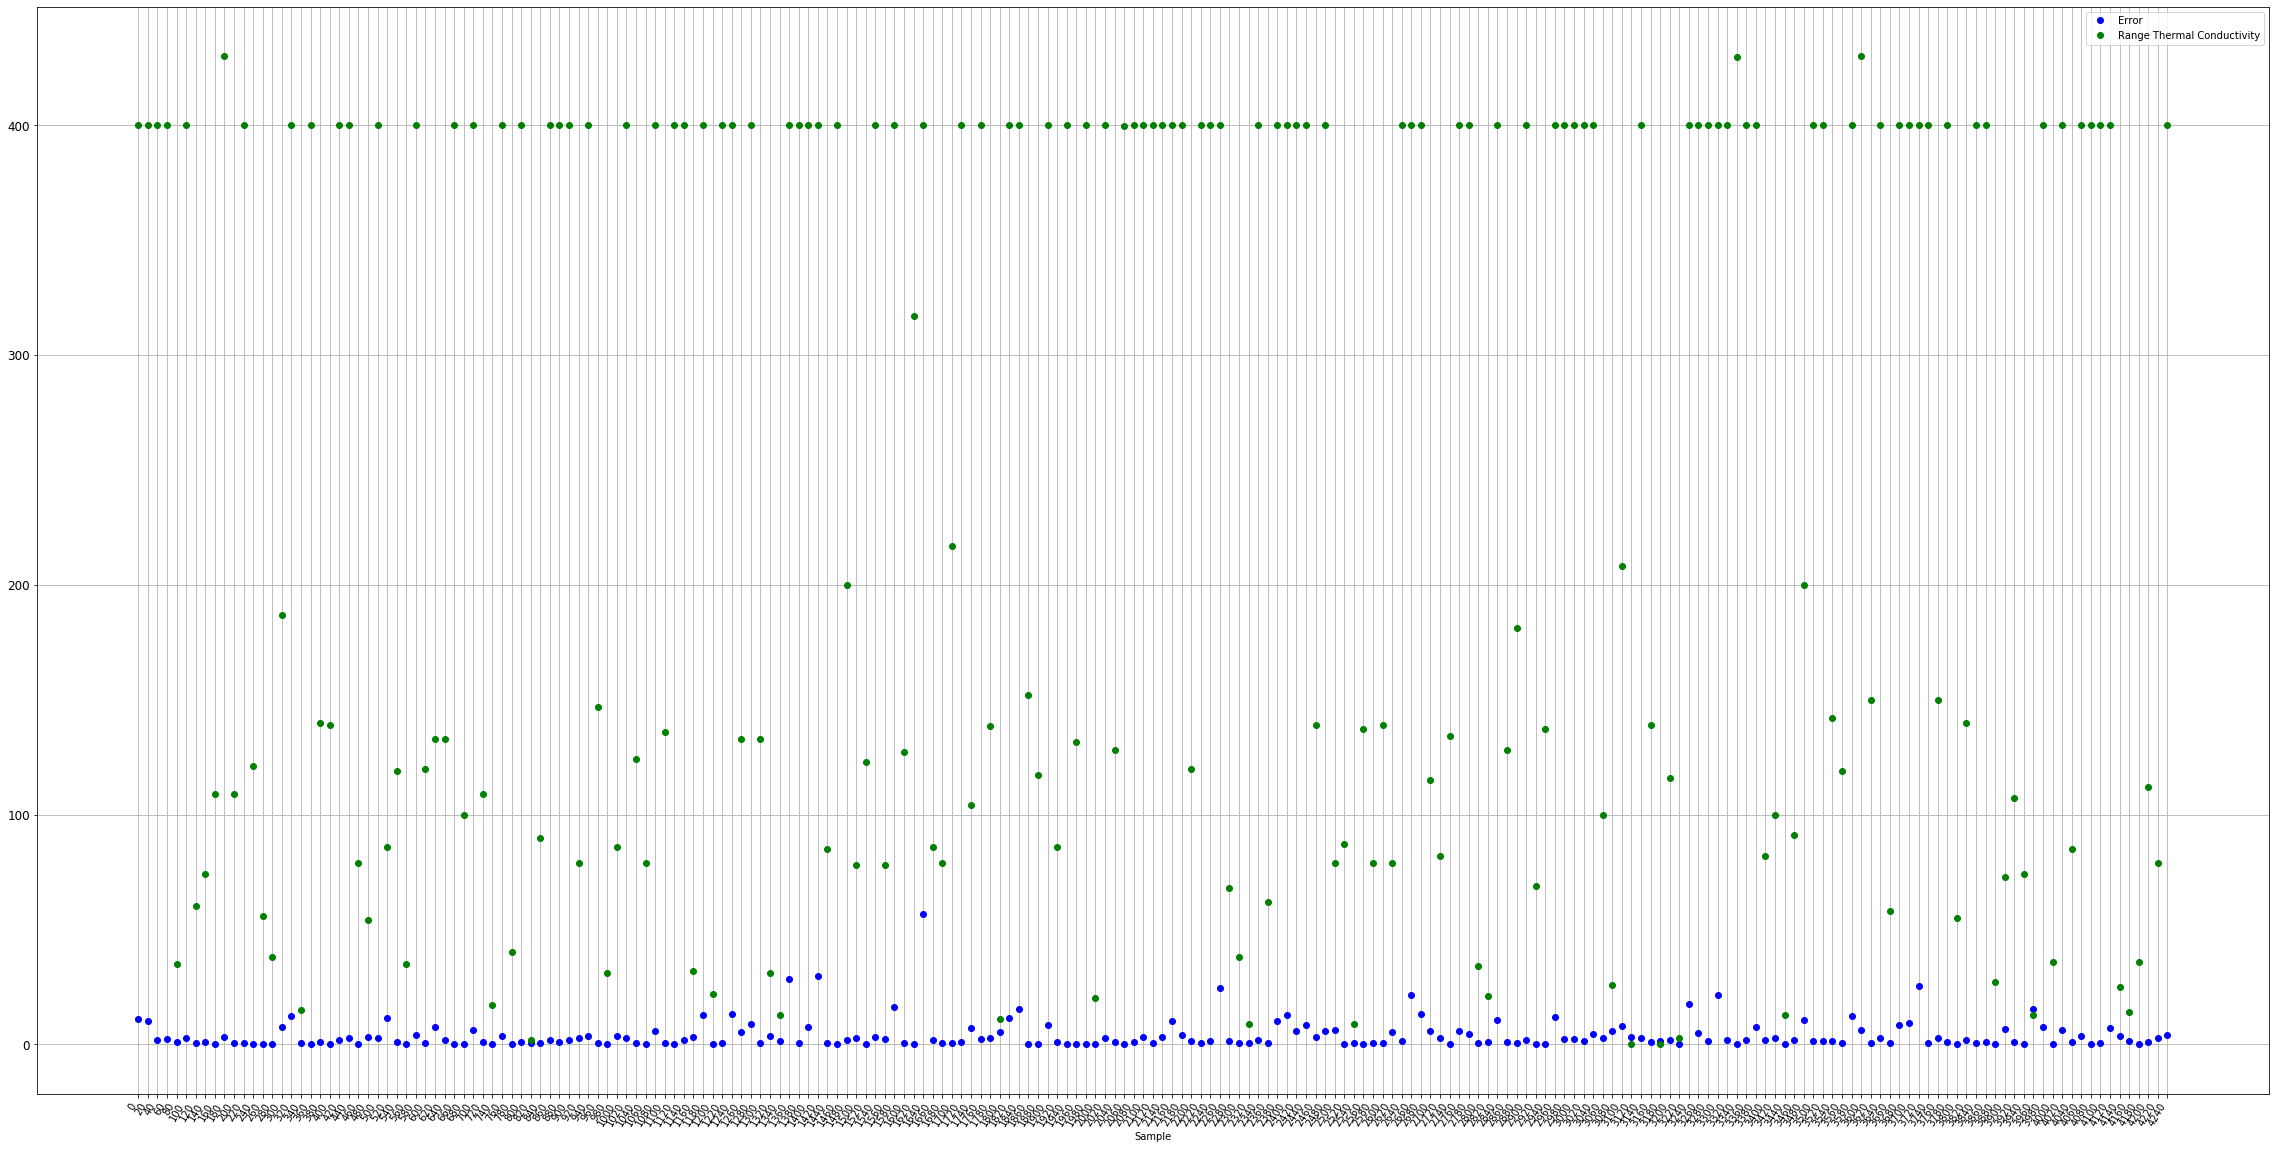

In [127]:
n = 20

X = np.arange(0, Ttest_SuperCond.shape[0]).reshape(-1, 1)
plt.rc('xtick',labelsize=10)
plt.rc('ytick',labelsize=12)

plt.figure(figsize=(40, 20))
plt.plot(X[::n], errors[::n], 'bo', X[::n], range_thermals[::n], 'go')
plt.legend(('Error', 'Range Thermal Conductivity'))
plt.xticks(X[::n], rotation=60, horizontalalignment='right')
plt.xlabel('Sample')
plt.grid(True)

However, it doesn't seem the overall data fully supports that conclusion as there are samples with a large range of thermal conductivity that produced significant error. There is likely a more complex combination of input parameters that is confusing the training algorithms.

# Random Forest with Reduction Revisited

Random forest achieved the second highest performance of the machine learning method, so it was of interest to see if altering the parameters would lead to a performance increase.

In [128]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA

In [ ]:
results_rfr = pd.DataFrame(columns=['n_component count', 'estimators', 'random state', 
                                    'Test Error', 'Percent Correct 5% Accuracy Test', 'Percent Correct 33% Accuracy Test',
                                    'Train Teror', 'Percent Correct 5% Accuracy Train', 'Percent Correct 33% Accuracy Train'])
for rstate in [40, 50, 60]:
    for components in range (1, 5):
        for estims in [1000, 2000, 4000]:
            ica = FastICA(n_components=components)
            ica.fit(Xtrain_SuperCondS, Ttrain_SuperCond)
            rfr = RandomForestRegressor(n_estimators = estims, random_state = rstate)

            rfr.fit(ica.transform(Xtrain_SuperCondS), Ttrain_SuperCond.reshape(-1));
            Y = rfr.predict(ica.transform(Xtest_SuperCondS))
            Y = Y.reshape(-1, 1)
            errors = abs(Y - Ttest_SuperCond)
            #print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
            n_correct_5 = ((abs(Y - Ttest_SuperCond) < (Ttest_SuperCond/20.))).sum()
            n_correct_33 = ((abs(Y - Ttest_SuperCond) < (Ttest_SuperCond/3.))).sum()

            Y = rfr.predict(ica.transform(Xtrain_SuperCondS))
            Y = Y.reshape(-1, 1)       

            errors_train = abs(Y - Ttrain_SuperCond)
            n_correct_5_train = ((abs(Y - Ttrain_SuperCond) < (Ttrain_SuperCond/20.))).sum()
            n_correct_33_train= ((abs(Y - Ttrain_SuperCond) < (Ttrain_SuperCond/3.))).sum()

            results_rfr.loc[len(results_rfr)] = [int(components), int(estims), int(rstate), 
                                                 round(np.mean(errors), 2), n_correct_5/Ttest_SuperCond.shape[0]*100, n_correct_33/Ttest_SuperCond.shape[0]*100,
                                                 round(np.mean(errors_train), 2), n_correct_5_train/Ttrain_SuperCond.shape[0]*100, n_correct_33_train/Ttrain_SuperCond.shape[0]*100]          



Increasing the number of trees in the forest did not improve performance significantly in most scenarios. Increasing the number of components in the dimensional reduction stage did seem to have an overall positive effect. Still, the performance did not match the nearest neighbors regression algorithm.

In [ ]:
results_rfr = results_rfr.sort_values('Percent Correct 5% Accuracy Test', ascending=False)
results_rfr

In [ ]:
best_comp = np.array(results_rfr[['n_component count']])
best_estim= np.array(results_rfr[['estimators']])[0]

best_comp = best_comp[0][0]
best_estim= best_estim[0]

print(best_comp)

ica = FastICA(n_components=best_comp.astype('int'))
ica.fit(Xtrain_SuperCondS, Ttrain_SuperCond)

rfr = RandomForestRegressor(n_estimators = best_estim.astype('int'), random_state = 50)
rfr.fit(ica.transform(Xtrain_SuperCondS), Ttrain_SuperCond.reshape(-1));
Y_test = rfr.predict(ica.transform(Xtest_SuperCondS))
Y_test = Y_test.reshape(-1, 1)

n = 20

X = np.arange(0, Ttest_SuperCond.shape[0]).reshape(-1, 1)
plt.rc('xtick',labelsize=10)
plt.rc('ytick',labelsize=12)

plt.figure(figsize=(40, 20))
plt.plot(X[::n], Y_test[::n], 'bo', X[::n], Ttest_SuperCond[::n], 'go')
plt.legend(('Predicted', 'Actual'))
plt.xticks(X[::n], rotation=60, horizontalalignment='right')
plt.xlabel('Sample')
plt.grid(True)

Gradient Boosting:
http://www.ccs.neu.edu/home/vip/teach/MLcourse/4_boosting/slides/gradient_boosting.pdf

Random Forest:
https://www.stat.berkeley.edu/~breiman/RandomForests/cc_home.htm

SVM:
https://people.eecs.berkeley.edu/~brecht/papers/07.rah.rec.nips.pdf

https://peekaboo-vision.blogspot.com/2012/12/kernel-approximations-for-efficient.html

Random forest Code:
https://www.datacamp.com/community/tutorials/random-forests-classifier-python

https://towardsdatascience.com/random-forest-in-python-24d0893d51c0

Nearest Neighbors Code:
https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html#sklearn.neighbors.KNeighborsRegressor

https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html

https://towardsdatascience.com/building-a-k-nearest-neighbors-k-nn-model-with-scikit-learn-51209555453a

SVM Code:
https://scikit-learn.org/stable/auto_examples/svm/plot_svm_regression.html#sphx-glr-auto-examples-svm-plot-svm-regression-py

Plotting Code:
Previous assignments in CS445, CS440, CS545